# FeatureMAP on synthetic data with Gaussian model.

In [1]:
import featuremap


import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

/Users/uqyyao4/opt/anaconda3/envs/featmap/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data loading

Read the expression data and pseudotime.

In [2]:
import numpy as np

def sample_multidimensional_mixture(w, means, covariances, n_samples=1):
    """
    Sample from a mixture of multivariate normal distributions.
    
    Parameters:
    w (list or np.array): Weights of the mixture components (should sum to 1).
    means (list of np.array): List of mean vectors for each component.
    covariances (list of np.array): List of covariance matrices for each component.
    n_samples (int): Number of samples to generate.
    
    Returns:
    np.array: Samples drawn from the mixture distribution.
    """
    # Ensure w is a numpy array
    w = np.array(w)
    
    # Check that the input is valid
    assert len(w) == len(means) == len(covariances), "Lengths of w, means, and covariances must be equal."
    assert np.isclose(np.sum(w), 1), "Weights w must sum to 1."
    
    # Step 1: Sample indices from the categorical distribution defined by w
    indices = np.random.choice(len(w), size=n_samples, p=w)
    
    # Step 2: Sample from the multivariate normal distribution corresponding to the selected index
    samples = np.array([np.random.multivariate_normal(means[i], covariances[i]) for i in indices])
    
    return samples, indices

# Updated weights for the mixture with 5 components
w = [0.2] * 5  # Equal weights for 5 components, summing to 1

# Radius of the circle for the components
radius = 3.5

# Calculate angles for the components on the circle
angles = np.linspace(0, 2 * np.pi, num=5, endpoint=False)

# Generate means for each component in 20-dimensional space
means = [
    np.array([radius * np.cos(angle), radius * np.sin(angle)] + [0] * 18)
    for angle in angles
]

# Covariance matrices for each of the 5 components (20x20 matrices)
covariances = [
    np.eye(20) * 1 for _ in range(5)  # Identity matrix for each component
]

# Number of samples to generate
n_samples = 3000

# Generate samples from the mixture model
samples, indices = sample_multidimensional_mixture(w, means, covariances, n_samples)

# Print the indices of the first 10 samples
print(indices[:10])

# Print the shape of the generated data
print(samples.shape)  # Should be (3000, 20)

# Print the first sample
print(samples[0])

data = samples
data_pseudotime = np.array(indices)


[0 3 0 3 2 4 1 2 4 4]
(3000, 20)
[ 2.61394025 -1.13951394  0.5811805  -0.38285456 -0.28469345  2.65062038
 -0.25076595 -0.01566102  0.94024081  1.35482354  0.44744085  0.54709336
  2.03053999  1.55472729  0.34172727  0.18547005  0.83298564 -0.46432653
 -1.08934003  0.54230462]


In [3]:
# statistics of data_pseudotime
import collections
counter=collections.Counter(data_pseudotime)
print(counter)


Counter({0: 645, 4: 598, 2: 594, 3: 587, 1: 576})


Visualize the data distribution.

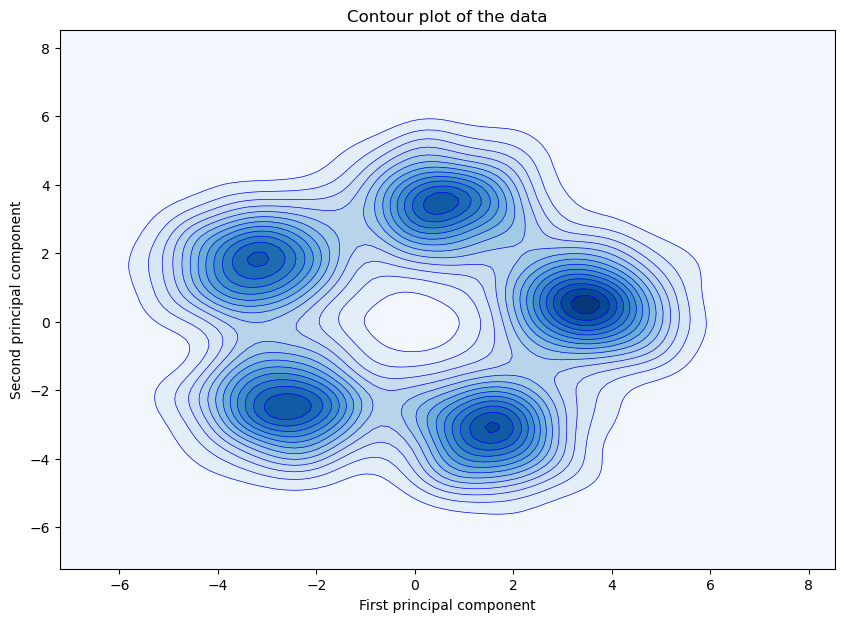

In [4]:
import numpy as np
# import pca
from sklearn.decomposition import PCA

# plot the data by PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1

min_lim = min(x_min, y_min)
max_lim = max(x_max, y_max)


# contour plot of the data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# Create a grid of points
x = np.linspace(min_lim, max_lim, 100)
y = np.linspace(min_lim, max_lim, 100)
X, Y = np.meshgrid(x, y)
# Stack the grid points to create a 2D input for the KDE model
xy = np.vstack([X.ravel(), Y.ravel()]).T

# Fit a KDE model to the data
kde = KernelDensity(bandwidth=0.5)
kde.fit(X_pca)

# Evaluate the KDE model on the grid
Z = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)

# Plot the contour plot
plt.figure(figsize=(10, 7))
# plt.contourf(X, Y, Z, cmap='Blues')
plt.contourf(X, Y, Z,levels=15, cmap='Blues',linewidths=0.5, )
# Add lines to mark level boundaries
contour_lines = plt.contour(X, Y, Z, levels=15, colors='blue', linewidths=0.5)

# plt.colorbar()
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_pseudotime, cmap='tab10')
plt.xlim(min_lim, max_lim)
plt.ylim(min_lim, max_lim)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Contour plot of the data')
plt.show()



### FeatureMAP to analyse the data.

FeatureMAP expression embedding.

In [5]:
from featuremap.featuremap_ import _preprocess_data

emb_svd, vh = _preprocess_data(data)



emb_featuremap = featuremap.FeatureMAP(
                    n_neighbors=30,
                    min_dist=0.3,
                    random_state=42,
                    n_epochs=400,
                    output_variation=False,
                    feat_gauge_coefficient=2,
                    verbose=True,
                    ).fit(emb_svd)

FeatureMAP(feat_gauge_coefficient=2, min_dist=0.3, n_epochs=400, random_state=42, verbose=True)
Wed Feb  5 14:48:22 2025 Construct fuzzy simplicial set
Wed Feb  5 14:48:22 2025 Finding Nearest Neighbors
Wed Feb  5 14:48:22 2025 Building RP forest with 8 trees


Wed Feb  5 14:48:30 2025 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	Stopping threshold met -- exiting after 3 iterations
Wed Feb  5 14:48:45 2025 Finished Nearest Neighbor Search
Wed Feb  5 14:48:48 2025 Construct embedding
Wed Feb  5 14:48:48 2025 Computing tangent space
Wed Feb  5 14:48:54 2025 Local SVD time is 5.115803956985474
Wed Feb  5 14:48:54 2025 Average over 5 times
Applying graph convolution for 5 iterations...
Graph convolution completed in 0.75 seconds
Wed Feb  5 14:48:54 2025 Tangent_space_approximation time is 5.902572870254517
k is 10
Wed Feb  5 14:49:16 2025 Tangent space embedding
Wed Feb  5 14:49:16 2025 Start optimizing layout


Epochs completed: 100%| ██████████ 400/400 [00:40]

Wed Feb  5 14:49:56 2025 Optimize layout time is 40.561551094055176
Wed Feb  5 14:49:56 2025 Finished embedding


mu is not added to adata


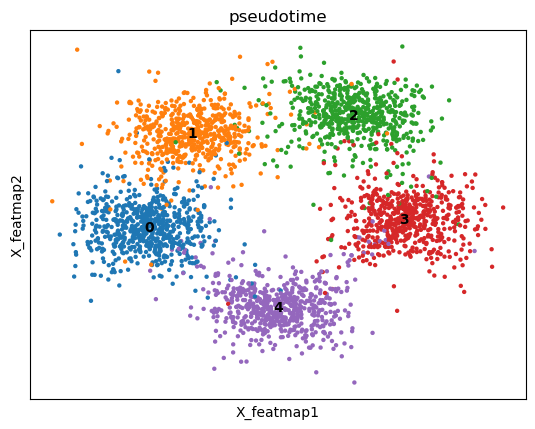

In [6]:
from featuremap import features
import importlib
importlib.reload(features)

adata = features.create_adata(X=data, emb_featuremap=emb_featuremap)

# adata.var_names = mnist.data.columns.to_list()

adata.obsm['X_svd'] = emb_svd
adata.varm['svd_vh'] = vh.T

adata.obsm['X_featmap'] = emb_featuremap.embedding_
adata.obs['pseudotime'] = data_pseudotime
adata.obs['pseudotime'] = adata.obs['pseudotime'].astype(str)   

# adata.obsm['X_umap'] = emb_umap
import scanpy as sc
sc.pl.embedding(adata, basis='X_featmap', color='pseudotime', legend_loc='on data')



FeatureMAP variation embedding

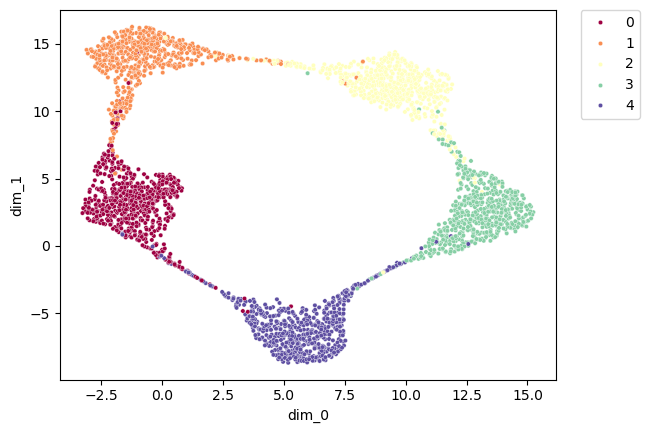

In [7]:

emb_featuremap_v = featuremap.FeatureMAP(
                    n_neighbors=30,
                    random_state=42,
                    output_variation=True,
                    n_epochs=400,
                    ).fit(emb_svd)

adata.obsm["X_featmap_v"] = emb_featuremap_v.embedding_

adata.obsm['variation_pc'] = emb_featuremap_v._featuremap_kwds['variation_pc']


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(dpi=100)

embedding_df = pd.DataFrame(adata.obsm["X_featmap_v"], index=adata.obs_names, columns=['dim_0', 'dim_1'])
embedding_df['pseudotime'] = data_pseudotime
sns.scatterplot(x='dim_0',y='dim_1', hue='pseudotime', data=embedding_df, palette='Spectral', s=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Benchmark with other DR methods

Visualize the data by different DR methods.

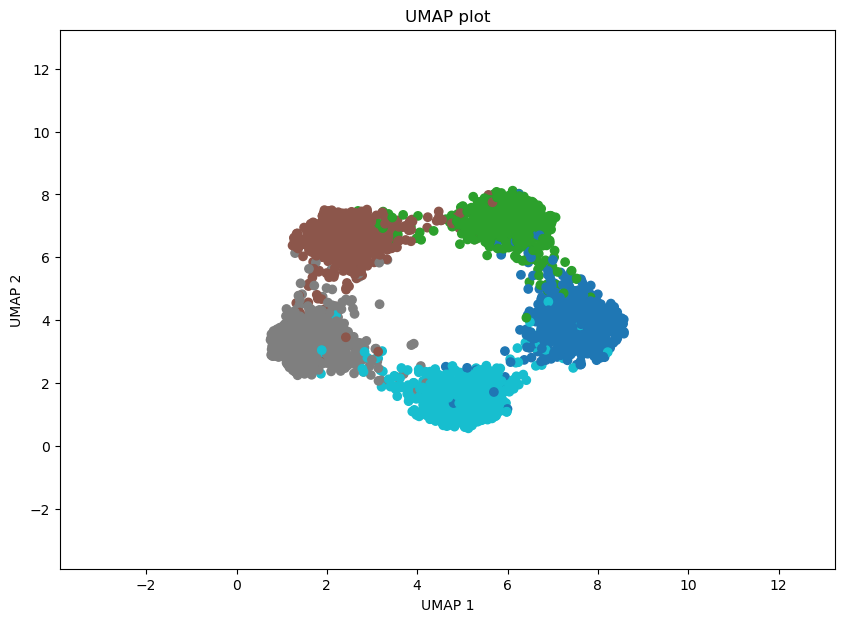

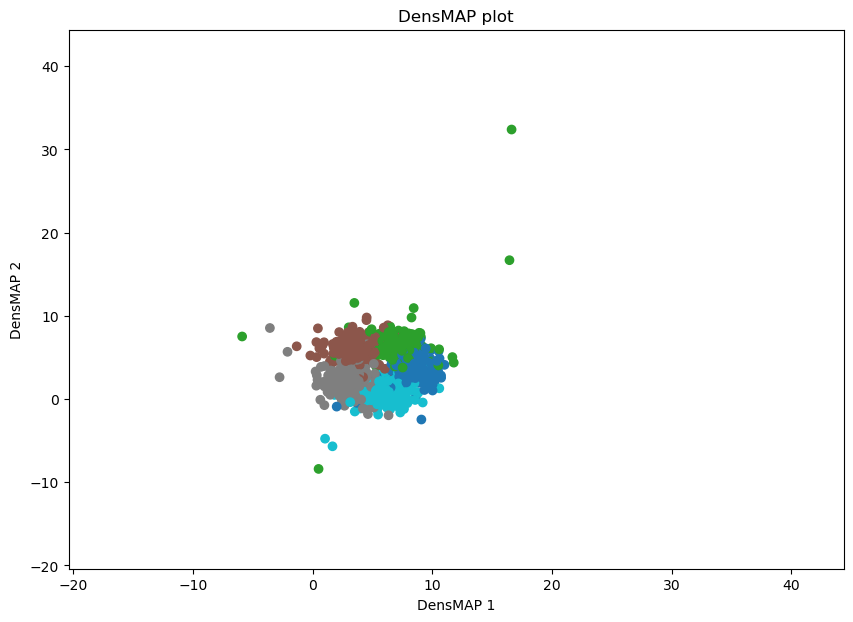

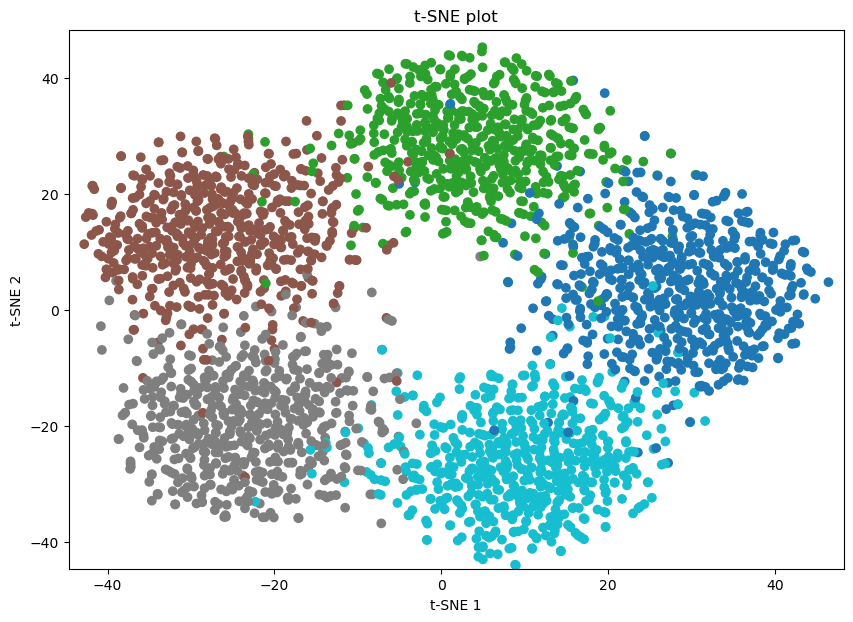

Calculating PHATE...
  Running PHATE on 3000 observations and 20 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.36 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.39 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.63 seconds.
    Calculating KMeans...
    Calculated KMeans in 14.69 seconds.
  Calculated landmark operator in 16.62 seconds.
  Calculating optimal t...
    Automatically selected t = 10
  Calculated optimal t in 33.27 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 34.43 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 6.21 seconds.
Calculated PHATE in 90.94 seconds.


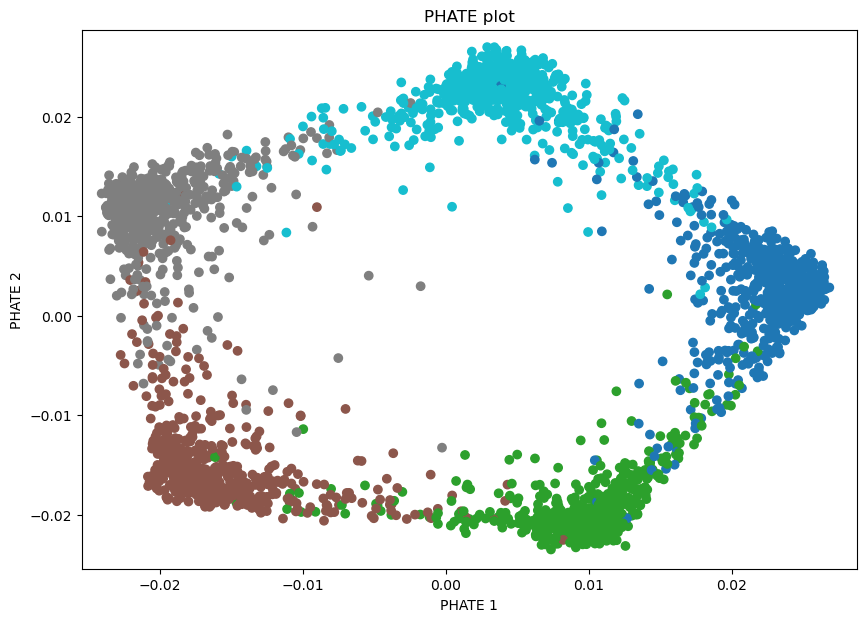

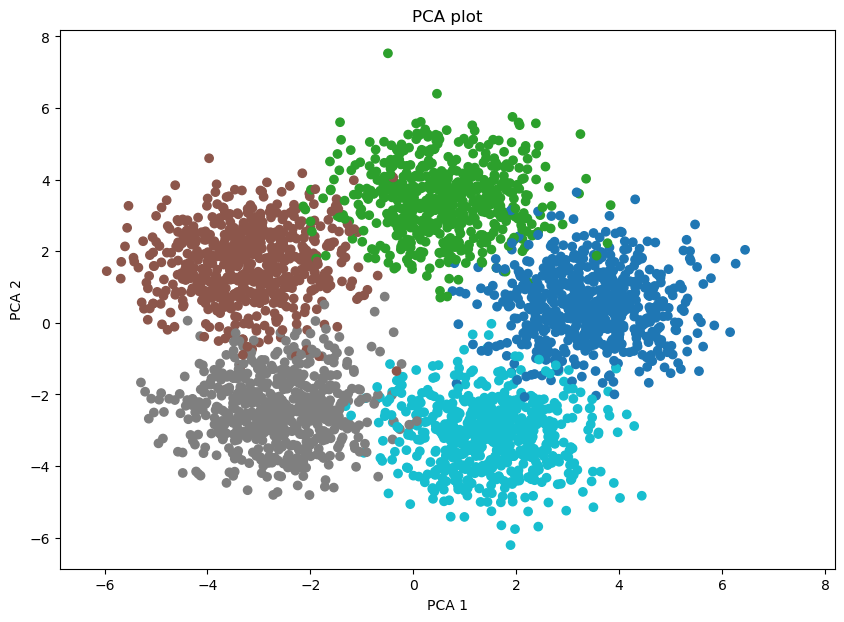

In [8]:
def plot_func(emb, label, method):

    x_min, x_max = emb[:, 0].min(), emb[:, 0].max()
    y_min, y_max = emb[:, 1].min(), emb[:, 1].max()

    min_lim = min(x_min - (x_min+x_max)/2, y_min - (y_min+y_max)/2)
    max_lim = max(x_max +(x_min+x_max)/2, y_max+ (y_min+y_max)/2)

    plt.figure(figsize=(10, 7))
    plt.scatter(emb[:, 0], emb[:, 1], c=label, cmap='tab10')
    plt.xlim(min_lim, max_lim)
    plt.ylim(min_lim, max_lim)
    # plt.colorbar()
    plt.xlabel(f'{method} 1')
    plt.ylabel(f'{method} 2')
    plt.title(f'{method} plot')

    plt.show()


### Benchmark with other DR methods
# UMAP plot
import umap
emb_umap = umap.UMAP().fit_transform(data)

adata.obsm['X_umap'] = emb_umap

# plot the data by UMAP
plot_func(emb_umap, data_pseudotime, 'UMAP')


# DensMAP plot
import umap
emb_densmap = umap.UMAP(densmap=True).fit_transform(data)

adata.obsm['X_densmap'] = emb_densmap


# plot the data by DensMAP
plot_func(emb_densmap, data_pseudotime, 'DensMAP')
# plot the data by t-SNE
from sklearn.manifold import TSNE
emb_tsne = TSNE(n_components=2, random_state=42).fit_transform(data)

adata.obsm['X_tsne'] = emb_tsne

plot_func(emb_tsne, data_pseudotime, 't-SNE')

# plot the data by phate
import phate
phate_op = phate.PHATE()
emb_phate = phate_op.fit_transform(data)

adata.obsm['X_phate'] = emb_phate

plot_func(emb_phate, data_pseudotime, 'PHATE')
# plot data by PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

adata.obsm['X_pca'] = X_pca

plot_func(X_pca, data_pseudotime, 'PCA')

Compute the PHATE graph for curvature and betweenness centrality calculation.

In [9]:
emb_phate_obj = phate_op.fit(data)
phate_graph = emb_phate_obj.graph.to_igraph()
# number of nodes
print(phate_graph.vcount())
# to networkx
phate_graph_nx = phate_graph.to_networkx()

Running PHATE on 3000 observations and 20 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.35 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated graph and diffusion operator in 0.38 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.44 seconds.
  Calculating KMeans...
The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
  Calculated KMeans in 11.20 seconds.
Calculated landmark operator in 12.77 seconds.
3000


### Transition and core states identification by density, curvature and betweenness centrality.

Use density to depict the transition and core states.

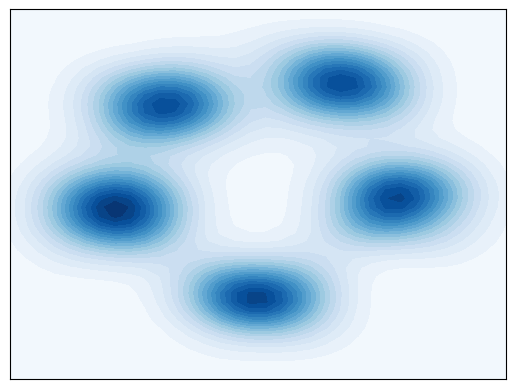

<Figure size 640x480 with 0 Axes>

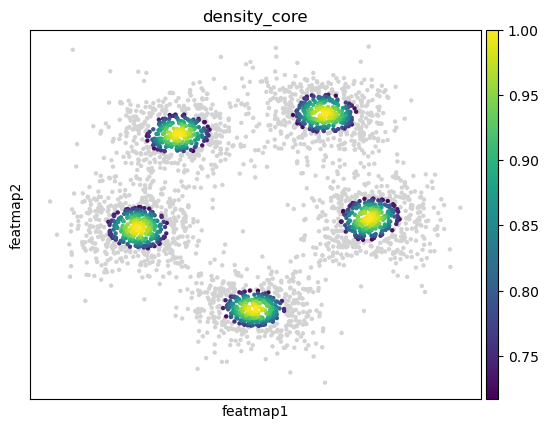

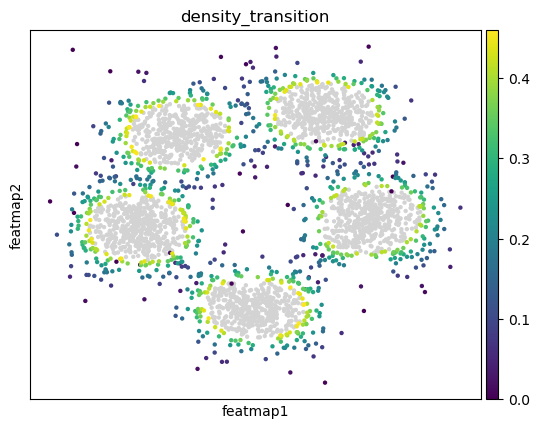

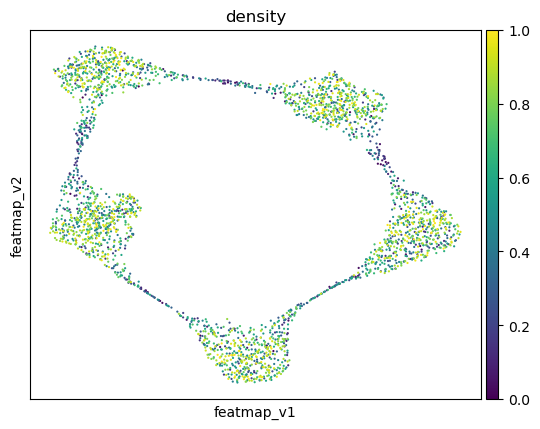

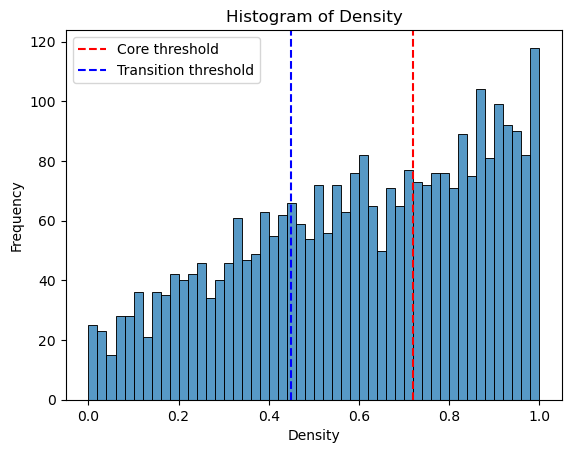

In [10]:
##################################
# Contour plot to show the density
######################################
from featuremap import core_transition_states
import importlib
importlib.reload(core_transition_states)

from featuremap.core_transition_states import plot_density
plot_density(adata)

#%%
#######################################################
# Compute core-states based on clusters
#########################################################

from featuremap import core_transition_states   
import importlib
importlib.reload(core_transition_states)


#%%
#######################################################
# Compute core-states based on clusters
#########################################################
quantile_core = 0.6
quantile_trans = 0.3


from featuremap.core_transition_states import compute_density
compute_density(adata, quantile_core=quantile_core, quantile_trans=quantile_trans)

# import scanpy as sc
# sc.pl.embedding(adata, basis='X_featmap_v', color='core_trans_states',  )
sc.pl.embedding(adata, 'featmap_v',legend_fontsize=6, s=10, legend_loc='on data', color='density')

# plot histogram of density
import seaborn as sns
import matplotlib.pyplot as plt

density = adata.obs['density']

plt.figure(dpi=100)
sns.histplot(density, bins=50)
plt.xlabel('Density')
plt.ylabel('Frequency')
plt.title('Histogram of Density')
threshold_core = density.quantile(quantile_core)
plt.axvline(threshold_core, color='red', linestyle='--', label='Core threshold')

threshold_trans = density.quantile(quantile_trans)
plt.axvline(threshold_trans, color='blue', linestyle='--', label='Transition threshold')
plt.legend()

plt.show()





Use curvature to depict transition and core states


1. Consider a car driving along a curvy road. The tighter the curve, the more difficult the driving is. In math we have a number, the curvature, that describes this "tightness". If the curvature is zero then the curve looks like a line near this point. While if the curvature is a large number, then the curve has a sharp bend.


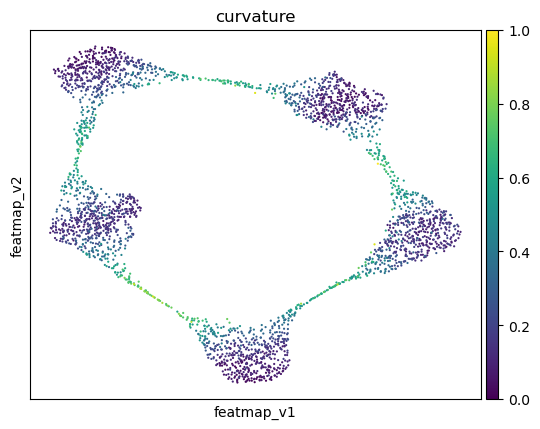

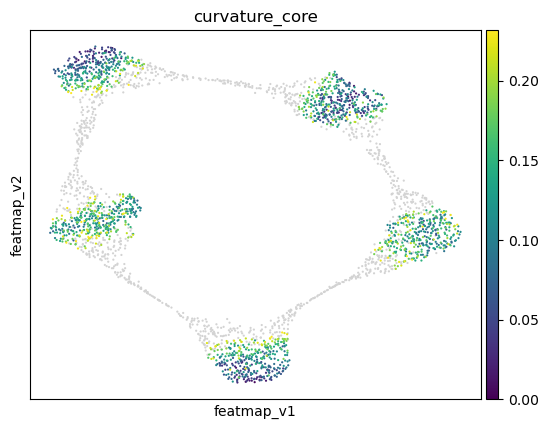

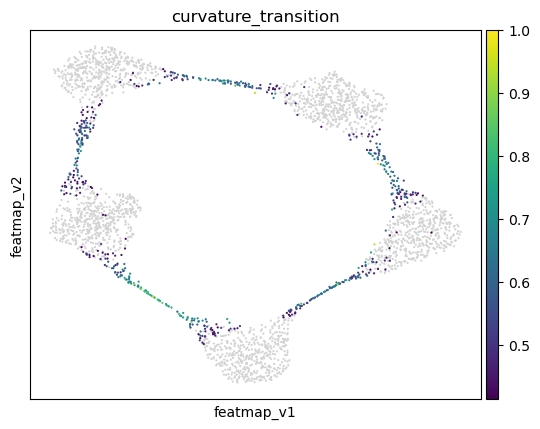

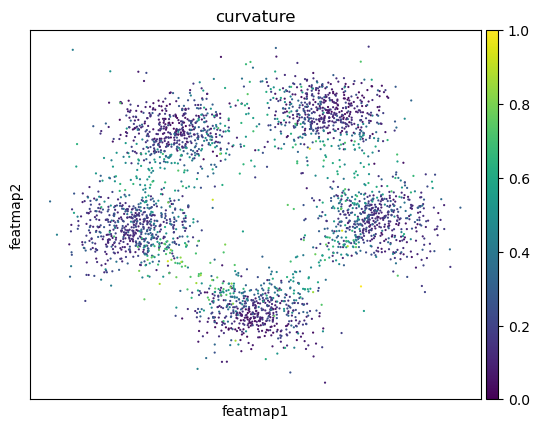

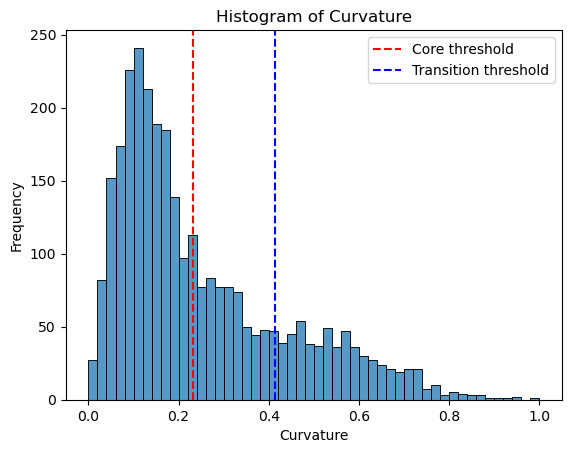

In [11]:
from featuremap import core_transition_states
import importlib
importlib.reload(core_transition_states)

quantile_core = 0.6
quantile_trans = 0.8
core_transition_states.compute_curvature(adata, emb_featuremap, quantile_core=quantile_core, quantile_trans=quantile_trans)

sc.pl.embedding(adata, 'featmap',legend_fontsize=6, s=10, legend_loc='on data', color='curvature')

# plot histogram of curvature
import seaborn as sns
import matplotlib.pyplot as plt

curvature = adata.obs['curvature']

plt.figure(dpi=100)
sns.histplot(curvature, bins=50)
plt.xlabel('Curvature')
plt.ylabel('Frequency')
plt.title('Histogram of Curvature')
threshold_core = curvature.quantile(quantile_core)
plt.axvline(threshold_core, color='red', linestyle='--', label=f'Core threshold')

threshold_trans = curvature.quantile(quantile_trans)
plt.axvline(threshold_trans, color='blue', linestyle='--', label=f'Transition threshold')
plt.legend()

plt.show()


 Use betweeness centrality to define transition states.

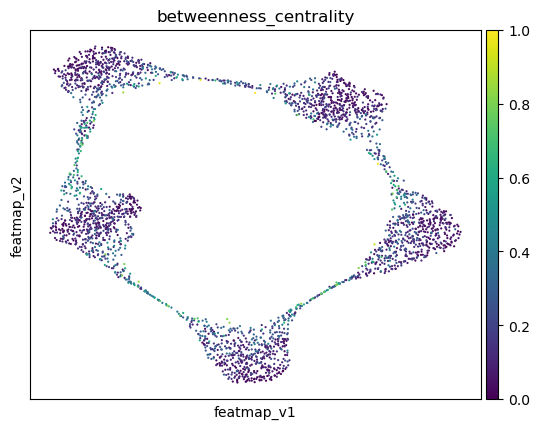

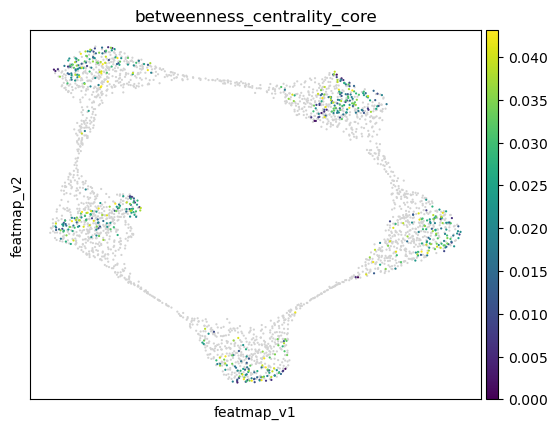

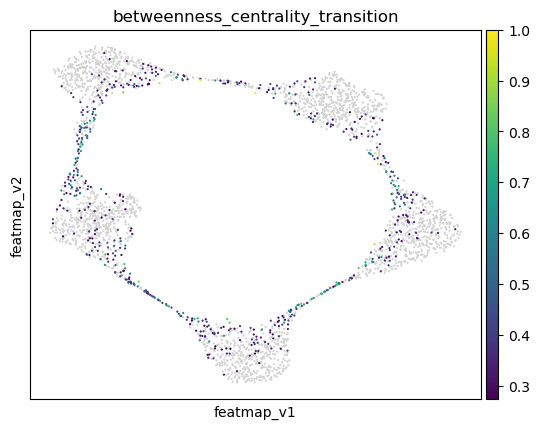

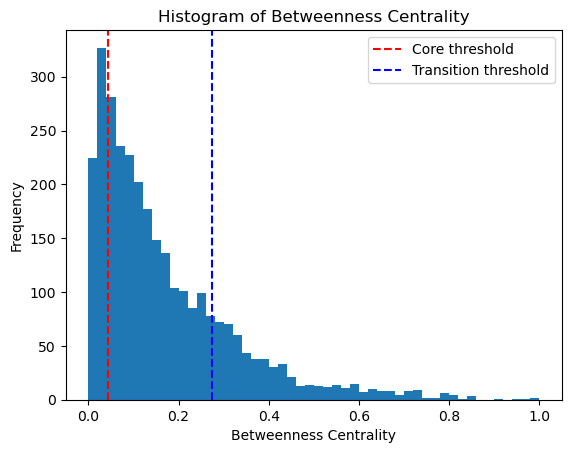

In [12]:
from featuremap import core_transition_states
import importlib
importlib.reload(core_transition_states)

quantile_trans = 0.8
quantile_core = 0.2


core_transition_states.compute_betweenness_centrality(adata, emb_featuremap, quantile_core=quantile_core, quantile_trans=quantile_trans)

betweenness_centrality = adata.obs['betweenness_centrality'].copy()
plt.hist(betweenness_centrality, bins=50)

threshold_core = betweenness_centrality.quantile(quantile_core)
plt.axvline(threshold_core, color='red', linestyle='--', label=f'Core threshold')

threshold_trans = betweenness_centrality.quantile(quantile_trans)
plt.axvline(threshold_trans, color='blue', linestyle='--', label=f'Transition threshold')  
plt.legend()

plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.title('Histogram of Betweenness Centrality')

plt.show()

Visualize the results of transition and core states by density, curvature and betweenness centrality.

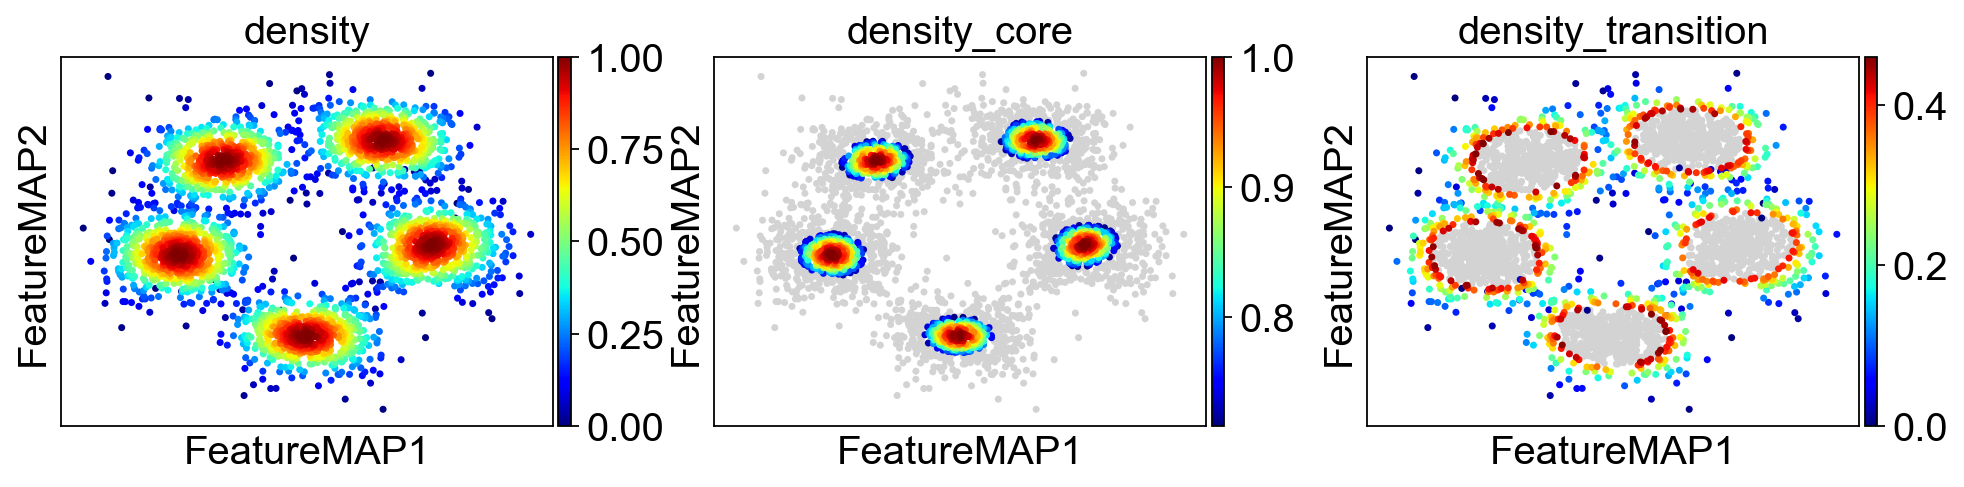

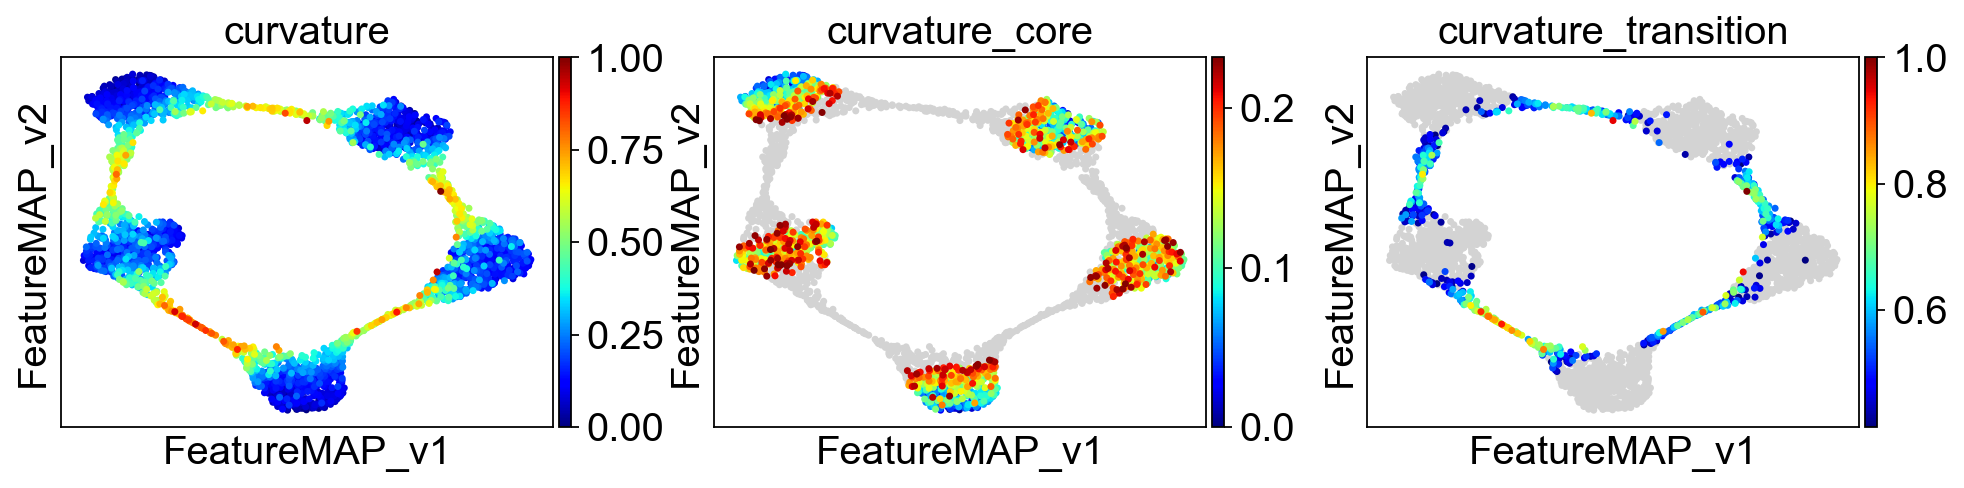

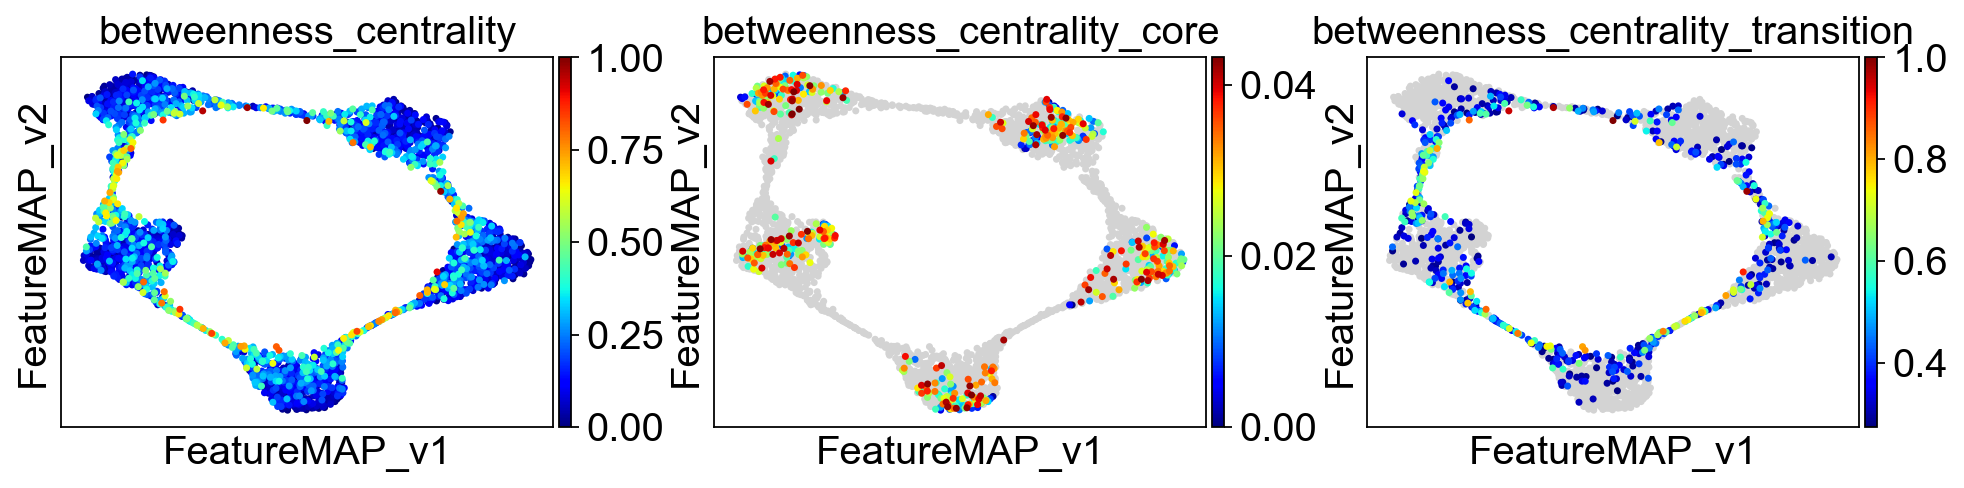

In [13]:
adata.obsm['X_FeatureMAP'] = adata.obsm['X_featmap']
adata.obsm['X_FeatureMAP_v'] = adata.obsm['X_featmap_v']


# set figure size
sc.set_figure_params(figsize=(4, 3),fontsize=18)
sc.pl.embedding(adata, basis='FeatureMAP', color=['density', 'density_core', 'density_transition'], cmap='jet', save='_cycle_density.png') 
sc.pl.embedding(adata, basis='FeatureMAP_v', color=['curvature', 'curvature_core', 'curvature_transition'], cmap='jet', save='_cycle_curvature.png')
sc.pl.embedding(adata, basis='FeatureMAP_v', color=['betweenness_centrality', 'betweenness_centrality_core', 'betweenness_centrality_transition'], 
                cmap='jet',save='_cycle_betweenness_centrality.png') 


 Union the results from density, curvature and betweenness centrality.

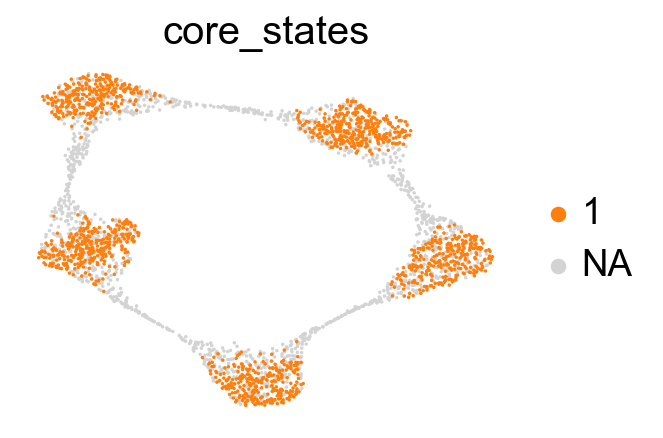

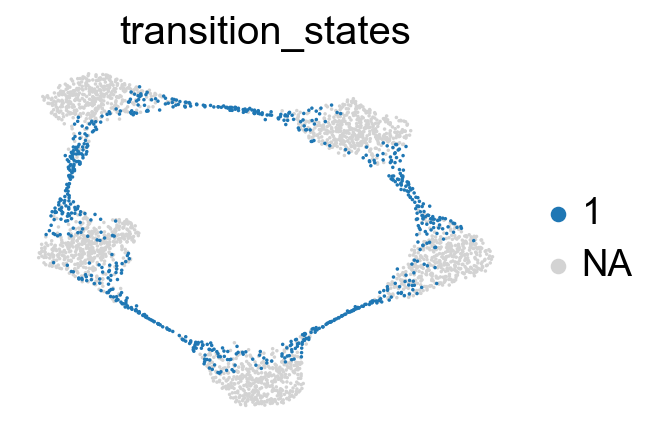

In [14]:
from featuremap import core_transition_states
import importlib
importlib.reload(core_transition_states)

core_transition_states.plot_core_transition_states(adata)

Compute the cluster state labels based on the percentage of core_states and transition_states for each cluster.


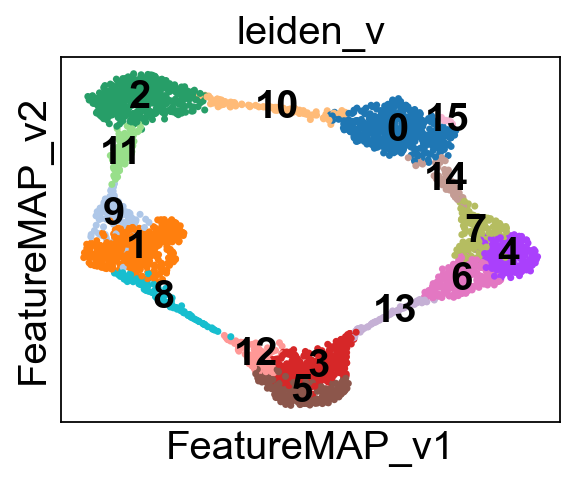

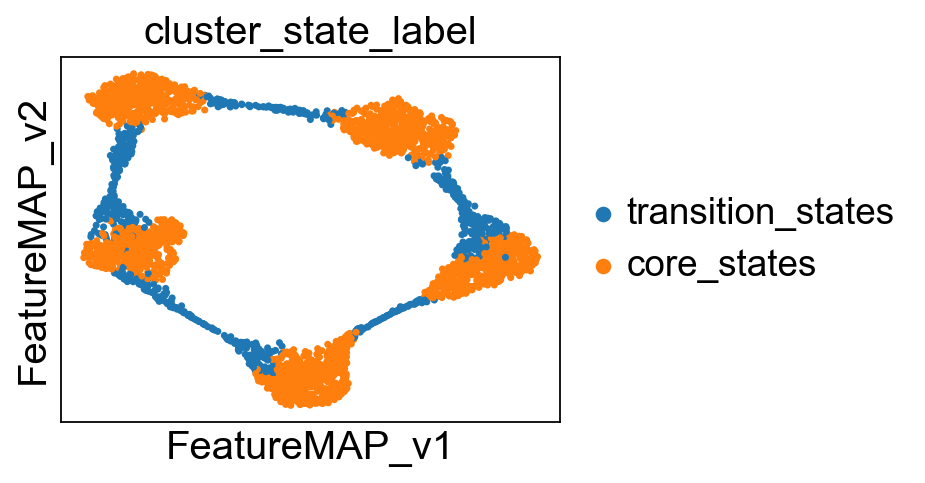

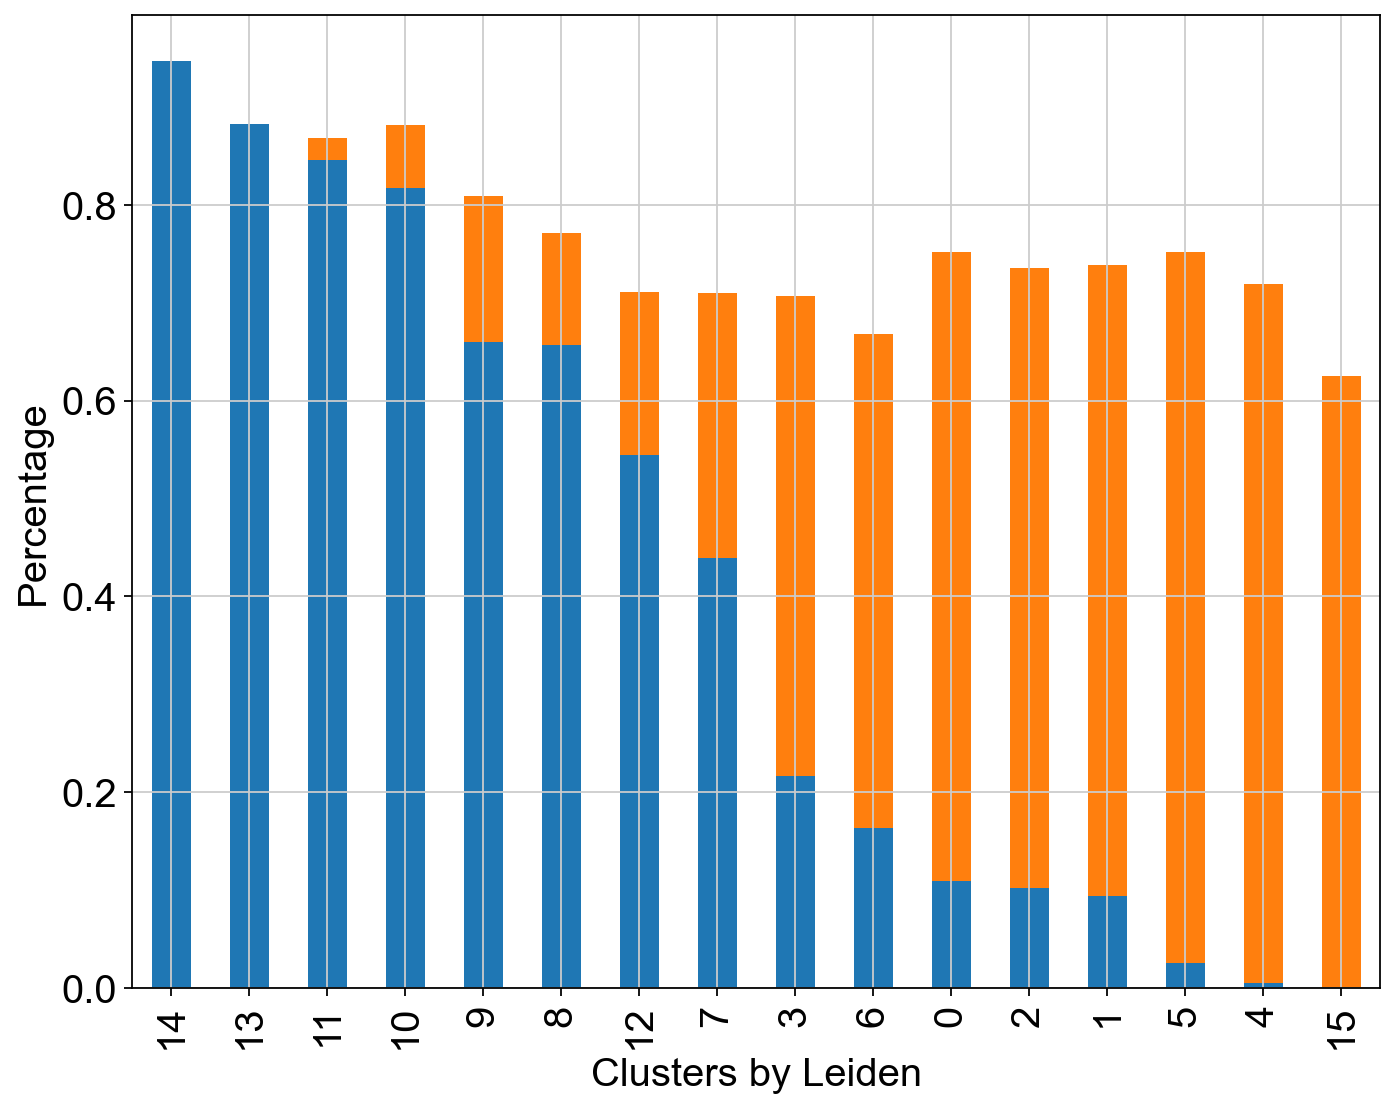

In [15]:
from featuremap import core_transition_states
import importlib
importlib.reload(core_transition_states)

import anndata as ad
adata_var = ad.AnnData(X=adata.obsm['variation_pc'], obs=adata.obs)
adata_var.obsm['X_featmap_v'] = adata.obsm['X_featmap_v']
# adata_var.obs['clusters'] = adata.obs['clusters']

# leiiden clustering on variation embedding
sc.pp.pca(adata_var)
sc.pp.neighbors(adata_var, n_neighbors=5,)
sc.tl.leiden(adata_var, resolution=0.6)

adata.obs['leiden_v'] = adata_var.obs['leiden']

# plot the leiden clustering on the variation embedding
sc.pl.embedding(adata, basis='FeatureMAP_v', color='leiden_v', legend_loc='on data')

core_transition_states.compute_cluster_state_labels(adata)

Project the identified transition and core states back to the original data.

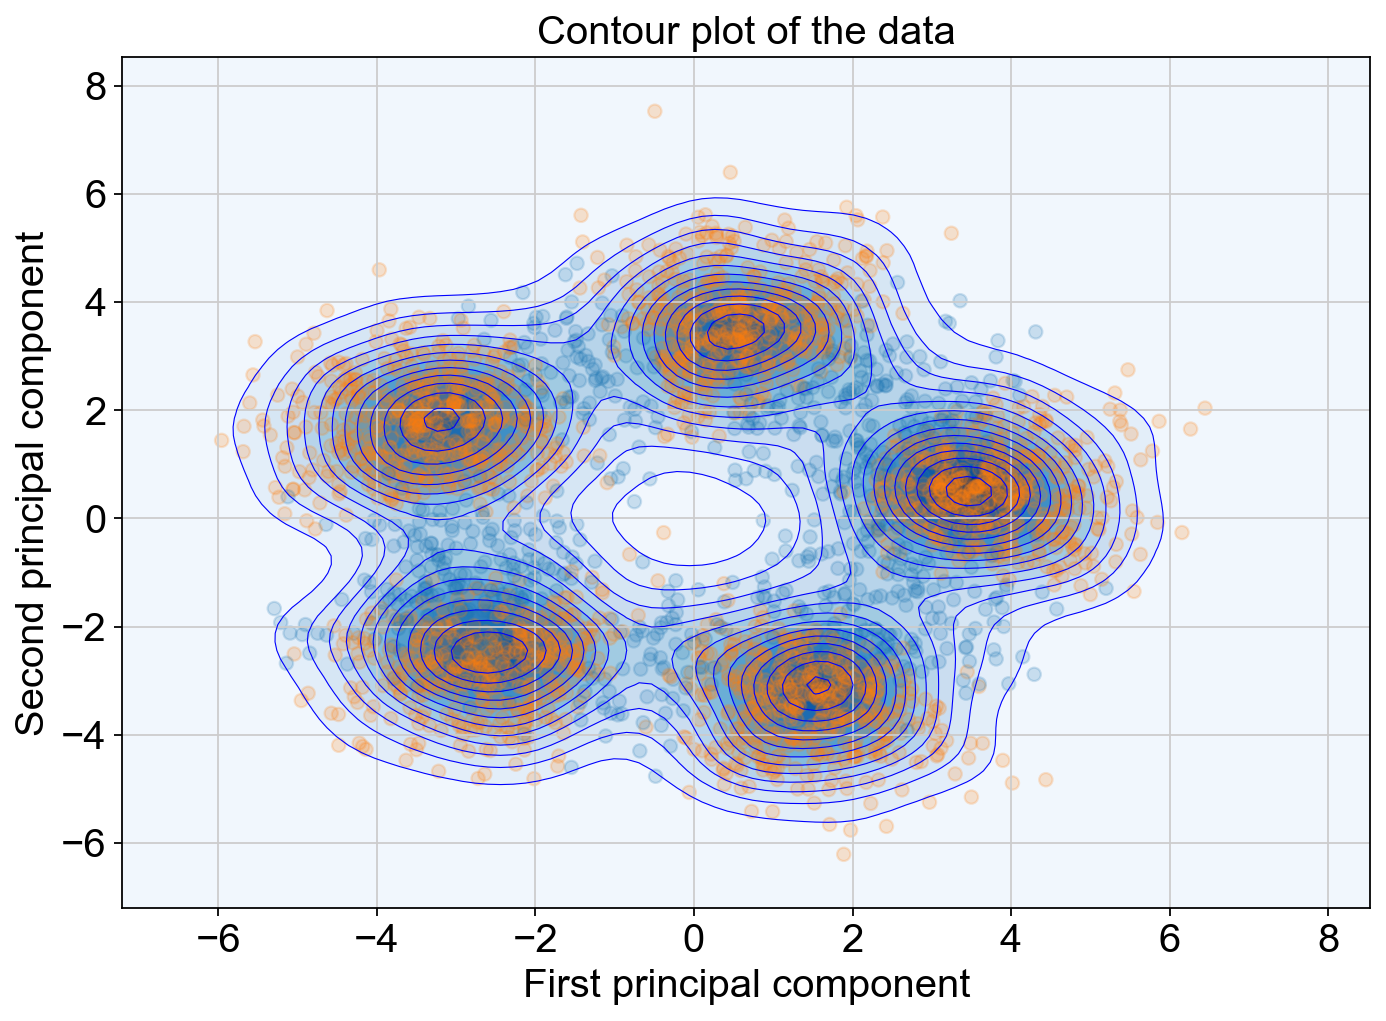

In [16]:
X_pca = adata.obsm['X_pca']

x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1

min_lim = min(x_min, y_min)
max_lim = max(x_max, y_max)


# contour plot of the data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# Create a grid of points
x = np.linspace(min_lim, max_lim, 100)
y = np.linspace(min_lim, max_lim, 100)
X, Y = np.meshgrid(x, y)
# Stack the grid points to create a 2D input for the KDE model
xy = np.vstack([X.ravel(), Y.ravel()]).T

# Fit a KDE model to the data
kde = KernelDensity(bandwidth=0.5)
kde.fit(X_pca)

# Evaluate the KDE model on the grid
Z = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)

color = adata.obs['cluster_state_label'].cat.codes

# create color map by [#1f77b4, #ff7f0e]
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#1f77b4', '#ff7f0e'])


# Plot the contour plot
plt.figure(figsize=(10, 7))
plt.contourf(X, Y, Z,levels=15, cmap='Blues',linewidths=0.5, )

# Add lines to mark level boundaries
contour_lines = plt.contour(X, Y, Z, levels=15, colors='blue', linewidths=0.5)

# plt.colorbar()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=color, cmap=cmap, alpha=0.2)
plt.xlim(min_lim, max_lim)
plt.ylim(min_lim, max_lim)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Contour plot of the data')
plt.show()


### Benchmark FeatureMAP with other methods to visualize transtion and core states.

Data visualization by different methods.

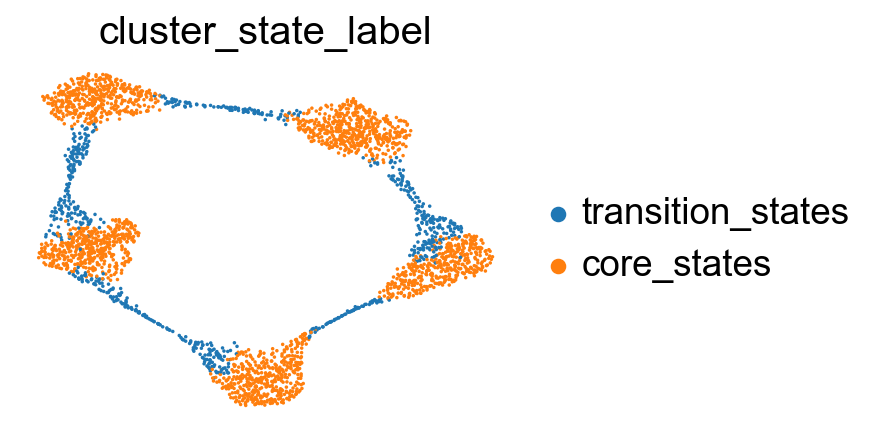

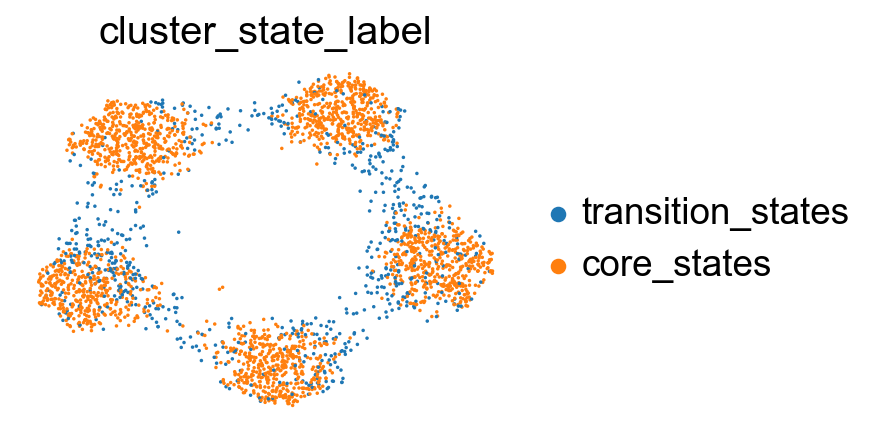

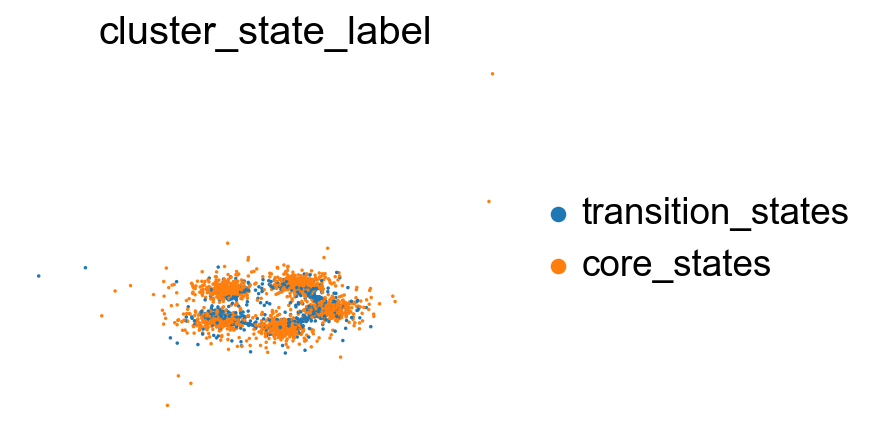

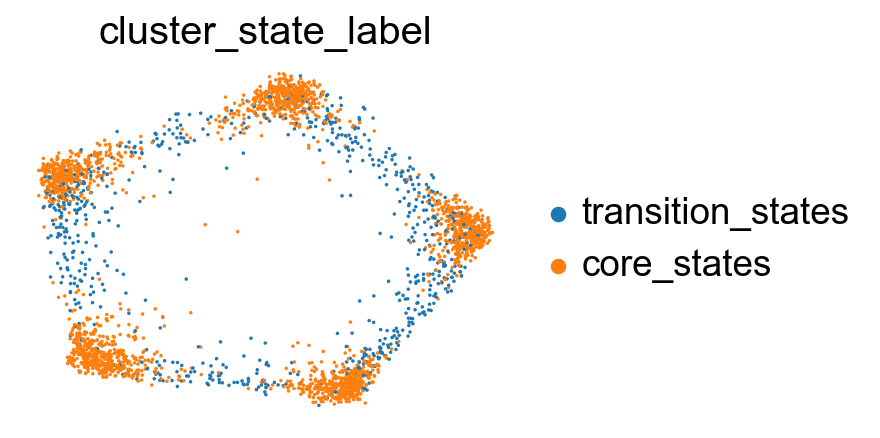

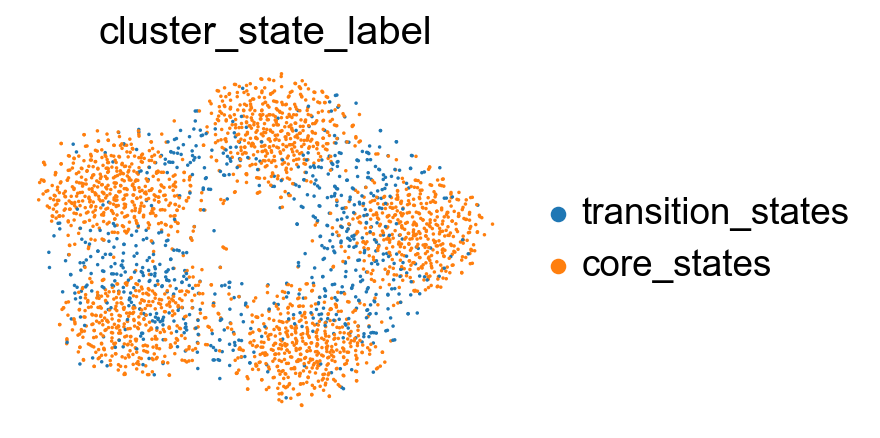

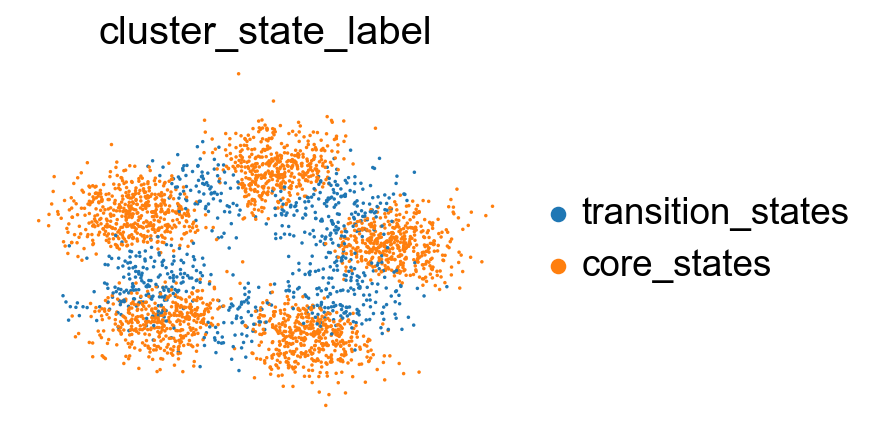

In [17]:
# visualize cluster_state_label in UMAP, DensMAP, PHATE, t-SNE, PCA
sc.pl.embedding(adata, basis='X_featmap_v', color='cluster_state_label', cmap='Blues_r', s=10, frameon=False)
sc.pl.embedding(adata, basis='X_umap', color='cluster_state_label', cmap='Blues_r', s=10, frameon=False)
sc.pl.embedding(adata, basis='X_densmap', color='cluster_state_label', cmap='Blues_r', s=10, frameon=False)
sc.pl.embedding(adata, basis='X_phate', color='cluster_state_label', cmap='Blues_r', s=10,  frameon=False)
sc.pl.embedding(adata, basis='X_tsne', color='cluster_state_label', cmap='Blues_r', s=10, frameon=False)
sc.pl.embedding(adata, basis='X_pca', color='cluster_state_label', cmap='Blues_r', s=10,frameon=False)

Compare the clustering coefficient in clustersing by different methods.

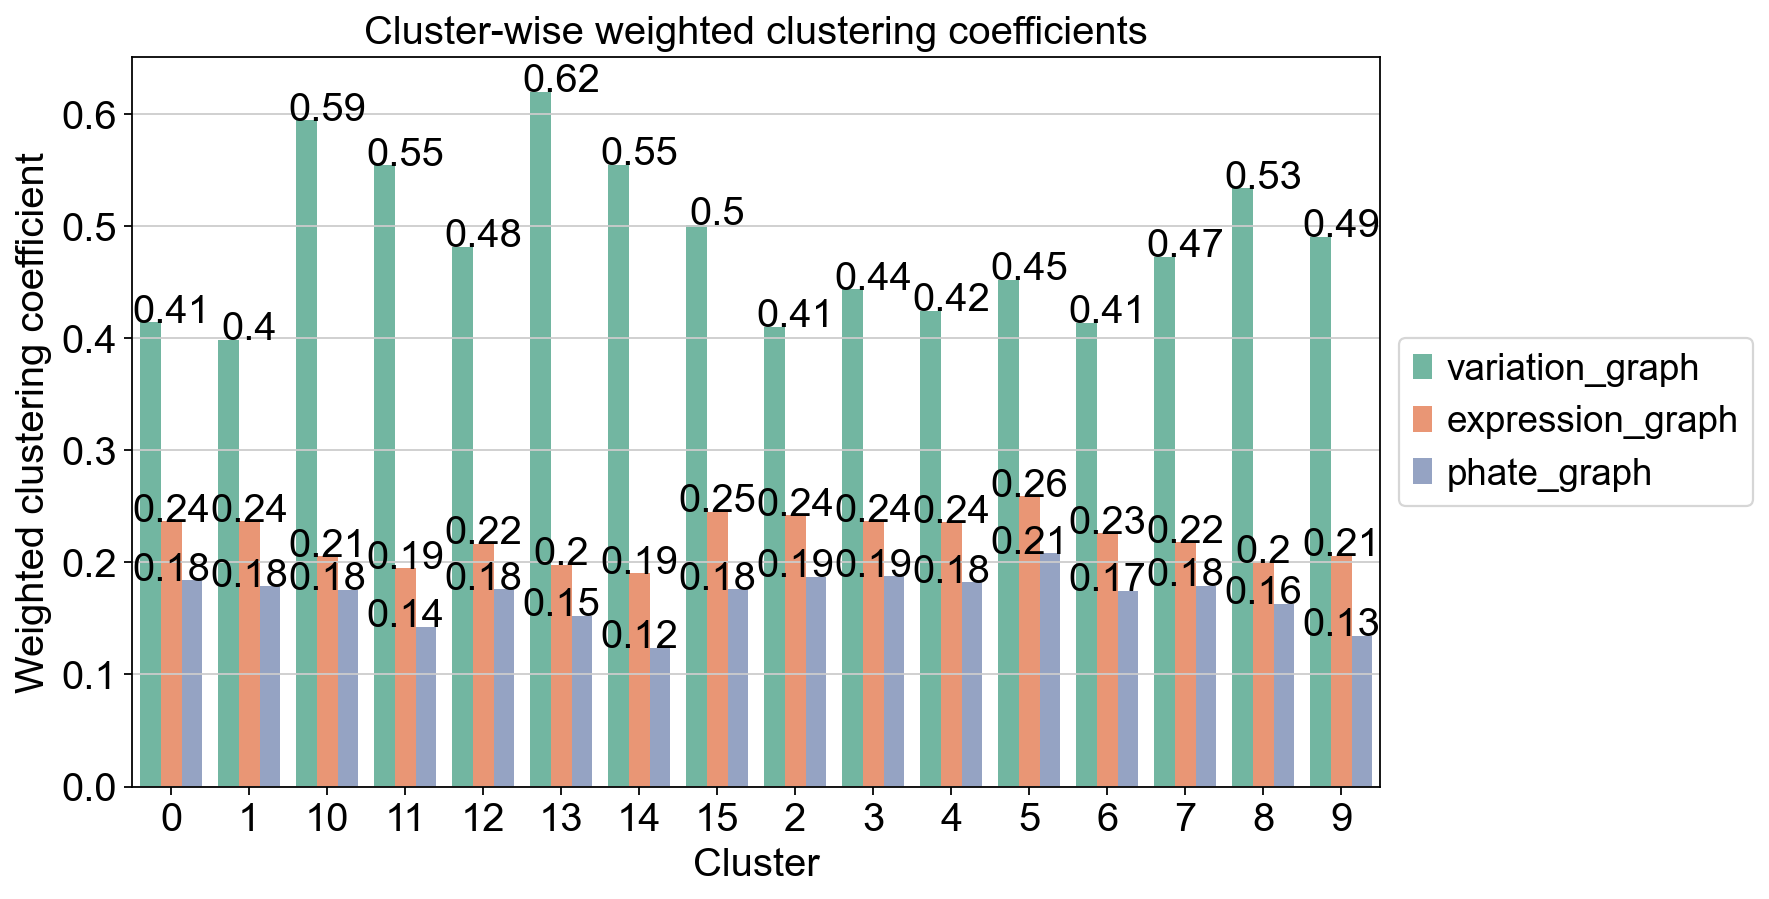

In [18]:
import networkx as nx
from featuremap import core_transition_states
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create graphs from feature maps
G_expr = nx.from_numpy_matrix(emb_featuremap.graph_)
G_var = nx.from_numpy_matrix(emb_featuremap_v._featuremap_kwds['graph_v'])
G_phate = phate_graph_nx

# Get clusters
clusters = adata.obs['leiden_v'].values.tolist()

# Compute weighted clustering coefficients
cluster_coefficients_var = core_transition_states.clustering_coefficient_by_cluster(G_var, clusters)
cluster_coefficients_expr = core_transition_states.clustering_coefficient_by_cluster(G_expr, clusters)
cluster_coefficients_phate = core_transition_states.clustering_coefficient_by_cluster(G_phate, clusters)

# Create DataFrames
df_var = pd.DataFrame({"Cluster": list(cluster_coefficients_var.keys()), "Coefficient": list(cluster_coefficients_var.values()), "type": 'variation_graph'})
df_expr = pd.DataFrame({"Cluster": list(cluster_coefficients_expr.keys()), "Coefficient": list(cluster_coefficients_expr.values()), "type": 'expression_graph'})
df_phate = pd.DataFrame({"Cluster": list(cluster_coefficients_phate.keys()), "Coefficient": list(cluster_coefficients_phate.values()), "type": 'phate_graph'})

# Combine DataFrames
df = pd.concat([df_var, df_expr, df_phate])

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Cluster", y="Coefficient", hue='type', palette='Set2', data=df)

# Add value on each bar
for index, row in df.iterrows():
    plt.text(row.name, row.Coefficient, round(row.Coefficient, 2), color='black', ha="center")

plt.title("Cluster-wise weighted clustering coefficients")
plt.xlabel("Cluster")
plt.ylabel("Weighted clustering coefficient")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


T-test: t_stat: 12.907455782325545, p_val: 3.6494243869363123e-09
ANOVA: f_stat: 79.65886233905583, p_val: 1.566387465071046e-10


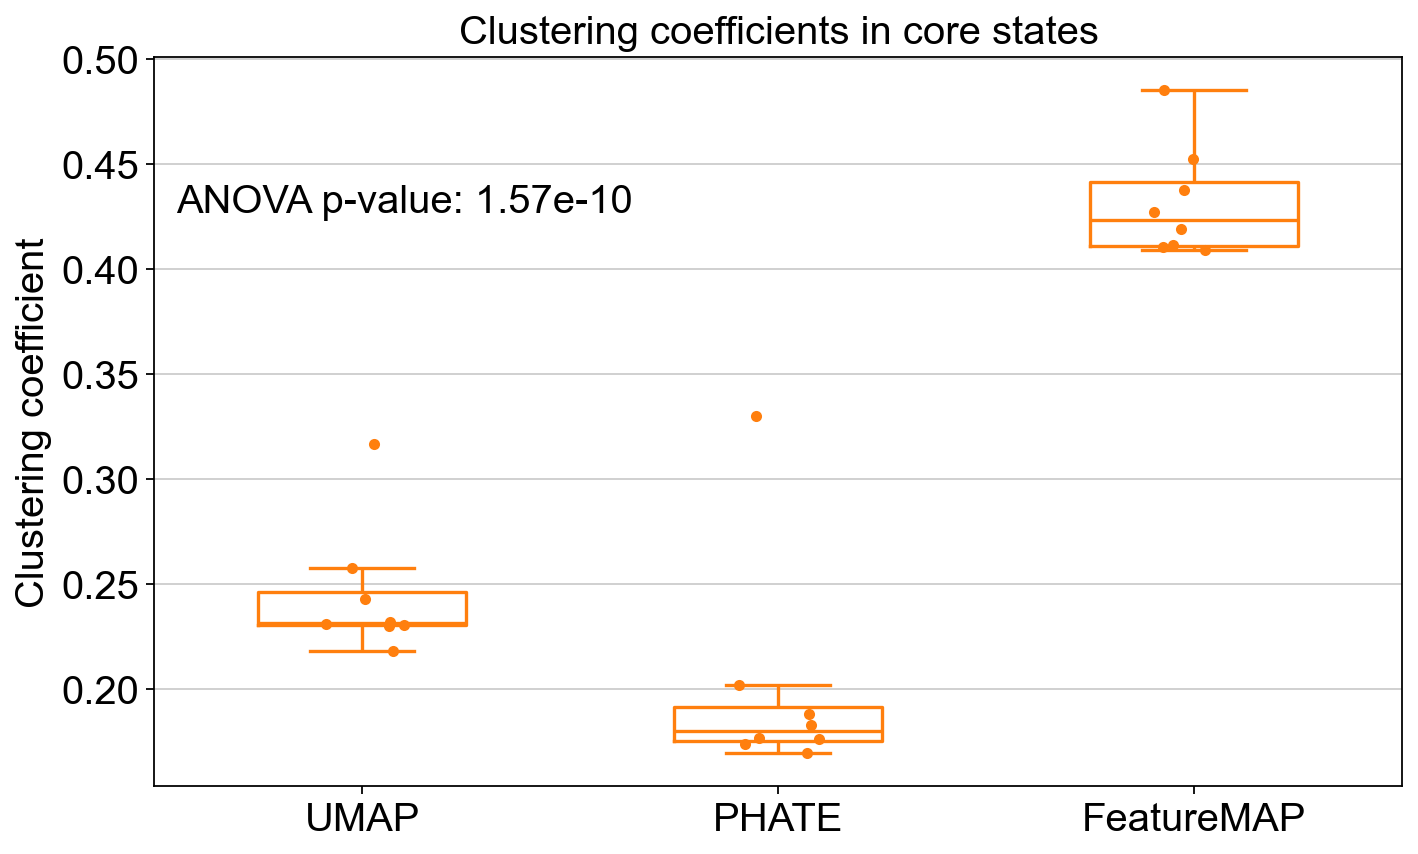

ANOVA: f_stat: 248.40643454392304, p_val: 2.4237497556759706e-15


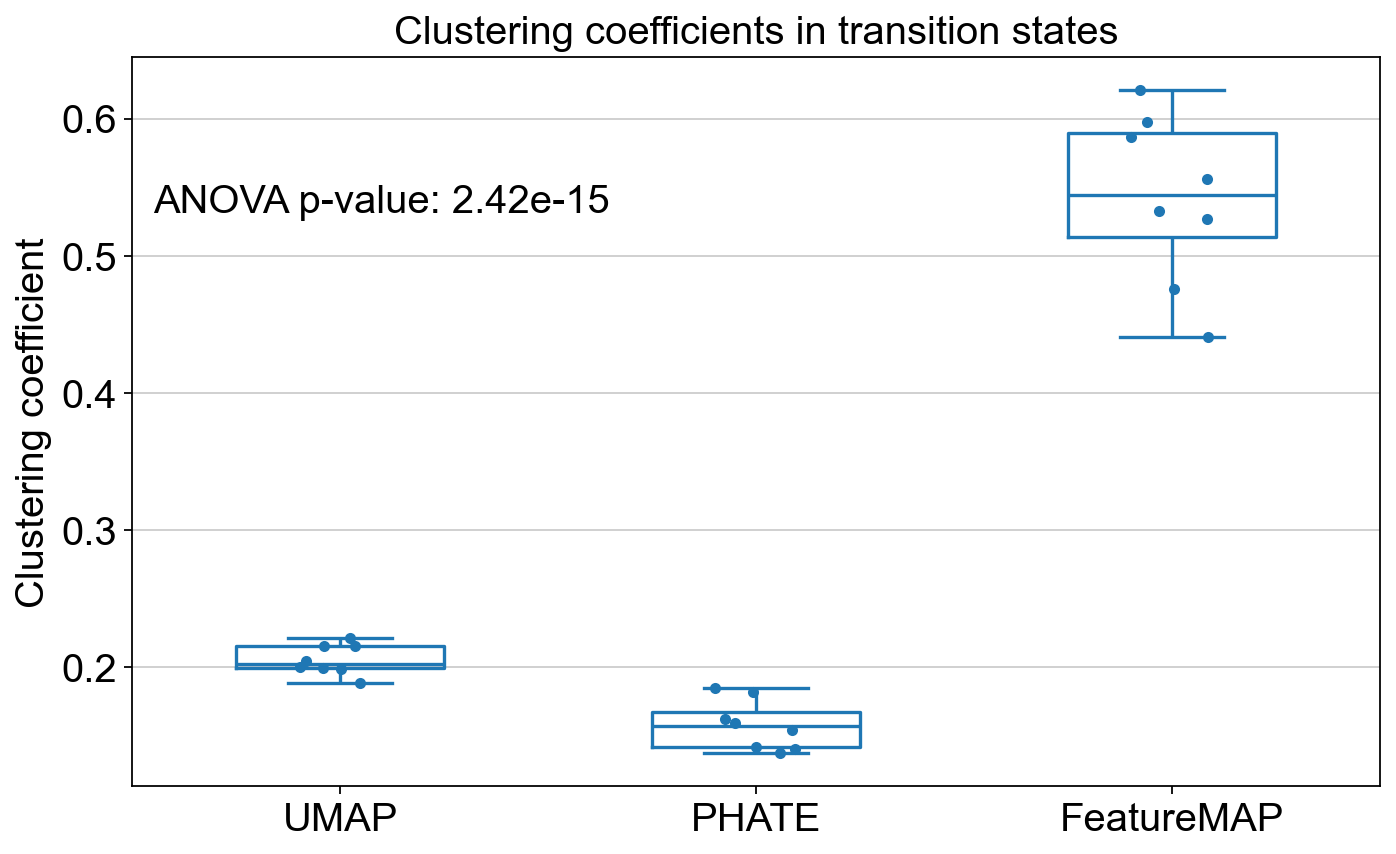

In [19]:
from featuremap import core_transition_states
import importlib
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway

importlib.reload(core_transition_states)

# Create graphs from feature maps
G_expr = nx.from_numpy_matrix(emb_featuremap.graph_)
G_var = nx.from_numpy_matrix(emb_featuremap_v._featuremap_kwds['graph_v'])
G_phate = phate_graph_nx

# Get clusters
clusters = adata.obs['leiden_v'].values.tolist()

# Compute weighted clustering coefficients
cluster_coefficients_var = core_transition_states.clustering_coefficient_by_cluster(G_var, clusters)
cluster_coefficients_expr = core_transition_states.clustering_coefficient_by_cluster(G_expr, clusters)
cluster_coefficients_phate = core_transition_states.clustering_coefficient_by_cluster(G_phate, clusters)

# Create DataFrames
df_var = pd.DataFrame({"Cluster": list(cluster_coefficients_var.keys()), "Coefficient": list(cluster_coefficients_var.values()), "type": 'variation_graph'})
df_expr = pd.DataFrame({"Cluster": list(cluster_coefficients_expr.keys()), "Coefficient": list(cluster_coefficients_expr.values()), "type": 'expression_graph'})
df_phate = pd.DataFrame({"Cluster": list(cluster_coefficients_phate.keys()), "Coefficient": list(cluster_coefficients_phate.values()), "type": 'phate_graph'})

# Combine DataFrames
coeff_all = []

# Helper function to append coefficients
def append_coefficients(state_type, cluster_coefficients):
    cluster_state_dict = adata.uns['cluster_state_dict']
    states = [cluster for cluster, state in cluster_state_dict.items() if state == state_type]
    return [cluster_coefficients[cluster] for cluster in states]

# Append coefficients for transition and core states
coeff_all.append(append_coefficients('transition_states', cluster_coefficients_expr))
coeff_all.append(append_coefficients('core_states', cluster_coefficients_expr))
coeff_all.append(append_coefficients('transition_states', cluster_coefficients_phate))
coeff_all.append(append_coefficients('core_states', cluster_coefficients_phate))
coeff_all.append(append_coefficients('transition_states', cluster_coefficients_var))
coeff_all.append(append_coefficients('core_states', cluster_coefficients_var))

# Core states coefficients
coeff_core_var = append_coefficients('core_states', cluster_coefficients_var)
coeff_core_expr = append_coefficients('core_states', cluster_coefficients_expr)
coeff_core_phate = append_coefficients('core_states', cluster_coefficients_phate)

# T-test and ANOVA
t_stat, p_val = ttest_ind(coeff_core_var, coeff_core_expr)
print(f'T-test: t_stat: {t_stat}, p_val: {p_val}')
f_stat, p_val = f_oneway(coeff_core_expr, coeff_core_phate, coeff_core_var)
print(f'ANOVA: f_stat: {f_stat}, p_val: {p_val}')


hatch_patterns = ['/','/', '\\','\\', 'x','x']  # Define hatch styles
# Plot core states
plt.figure(figsize=(10, 6))
box = sns.boxplot(data=[coeff_core_expr, coeff_core_phate, coeff_core_var], color=plt.get_cmap('tab10')(1), fill=False, width=0.5, showfliers=False)
for patch, hatch in zip(box.patches, hatch_patterns):
    patch.set_hatch(hatch)
sns.stripplot(data=[coeff_core_expr, coeff_core_phate, coeff_core_var], color=plt.get_cmap('tab10')(1), jitter=True, dodge=True)
plt.xticks(ticks=[0, 1, 2], labels=['UMAP', 'PHATE', 'FeatureMAP'])
plt.title("Clustering coefficients in core states")
plt.ylabel("Clustering coefficient")
plt.text(0.2, 0.8, f"ANOVA p-value: {p_val:.2e}", ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

# Transition states coefficients
coeff_trans_var = append_coefficients('transition_states', cluster_coefficients_var)
coeff_trans_expr = append_coefficients('transition_states', cluster_coefficients_expr)
coeff_trans_phate = append_coefficients('transition_states', cluster_coefficients_phate)

# ANOVA for transition states
f_stat, p_val = f_oneway(coeff_trans_expr, coeff_trans_phate, coeff_trans_var)
print(f'ANOVA: f_stat: {f_stat}, p_val: {p_val}')

# Plot transition states
plt.figure(figsize=(10, 6))
box = sns.boxplot(data=[coeff_trans_expr, coeff_trans_phate, coeff_trans_var], color=plt.get_cmap('tab10')(0), fill=False, width=0.5, showfliers=False)
for patch, hatch in zip(box.patches, hatch_patterns):
    patch.set_hatch(hatch)
sns.stripplot(data=[coeff_trans_expr, coeff_trans_phate, coeff_trans_var], color=plt.get_cmap('tab10')(0), jitter=True, dodge=True)
plt.xticks(ticks=[0, 1, 2], labels=['UMAP', 'PHATE', 'FeatureMAP'])
plt.title("Clustering coefficients in transition states")
plt.ylabel("Clustering coefficient")
plt.text(0.2, 0.8, f"ANOVA p-value: {p_val:.2e}", ha='center', va='center', transform=plt.gca().transAxes)
plt.show()


Compare Silhouette score of different methods.

T-test: t_stat: 3.0531034547131193, p_val: 0.008596691183976178
ANOVA: f_stat: 1.3974476185820628, p_val: 0.2692915497557866


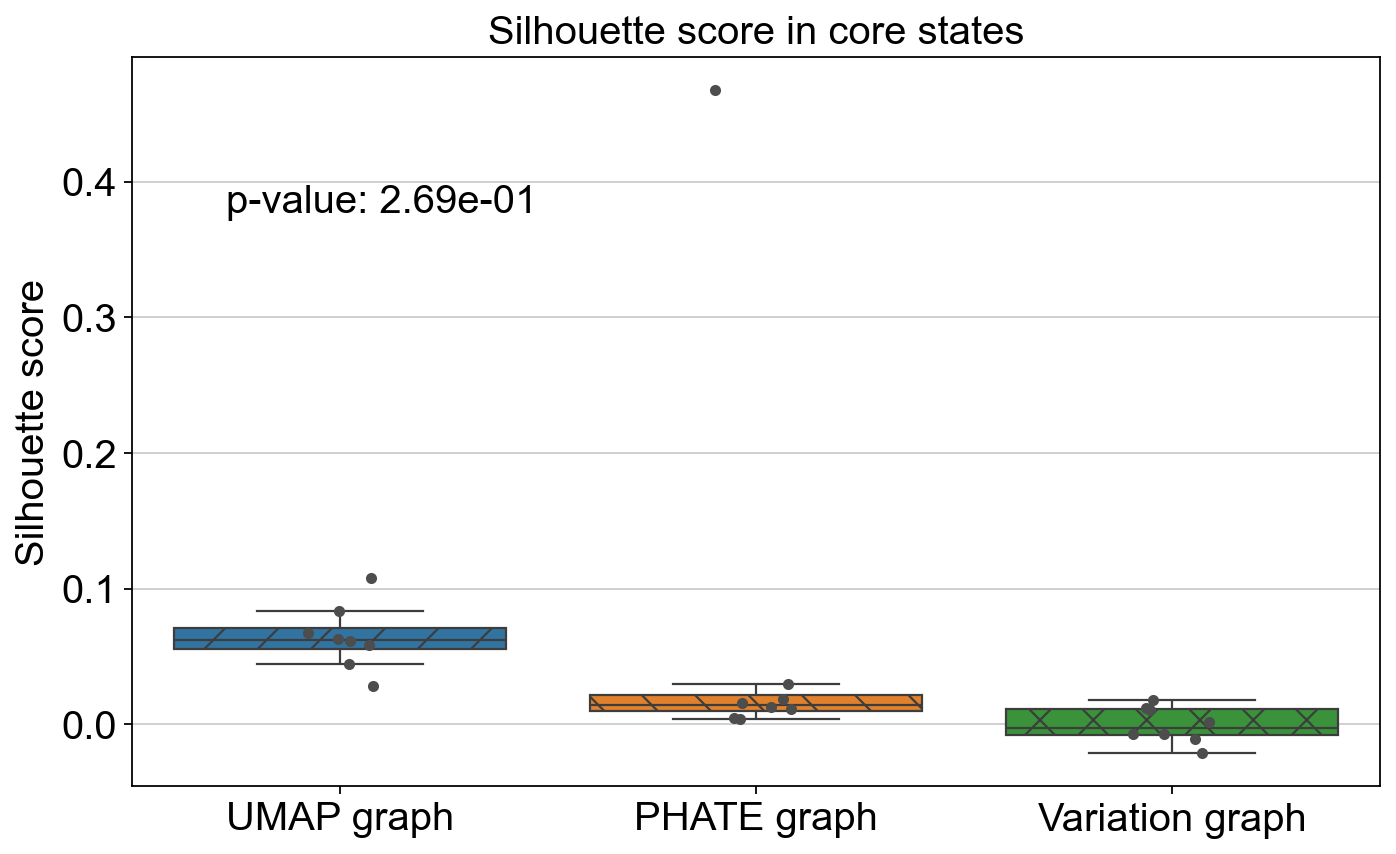

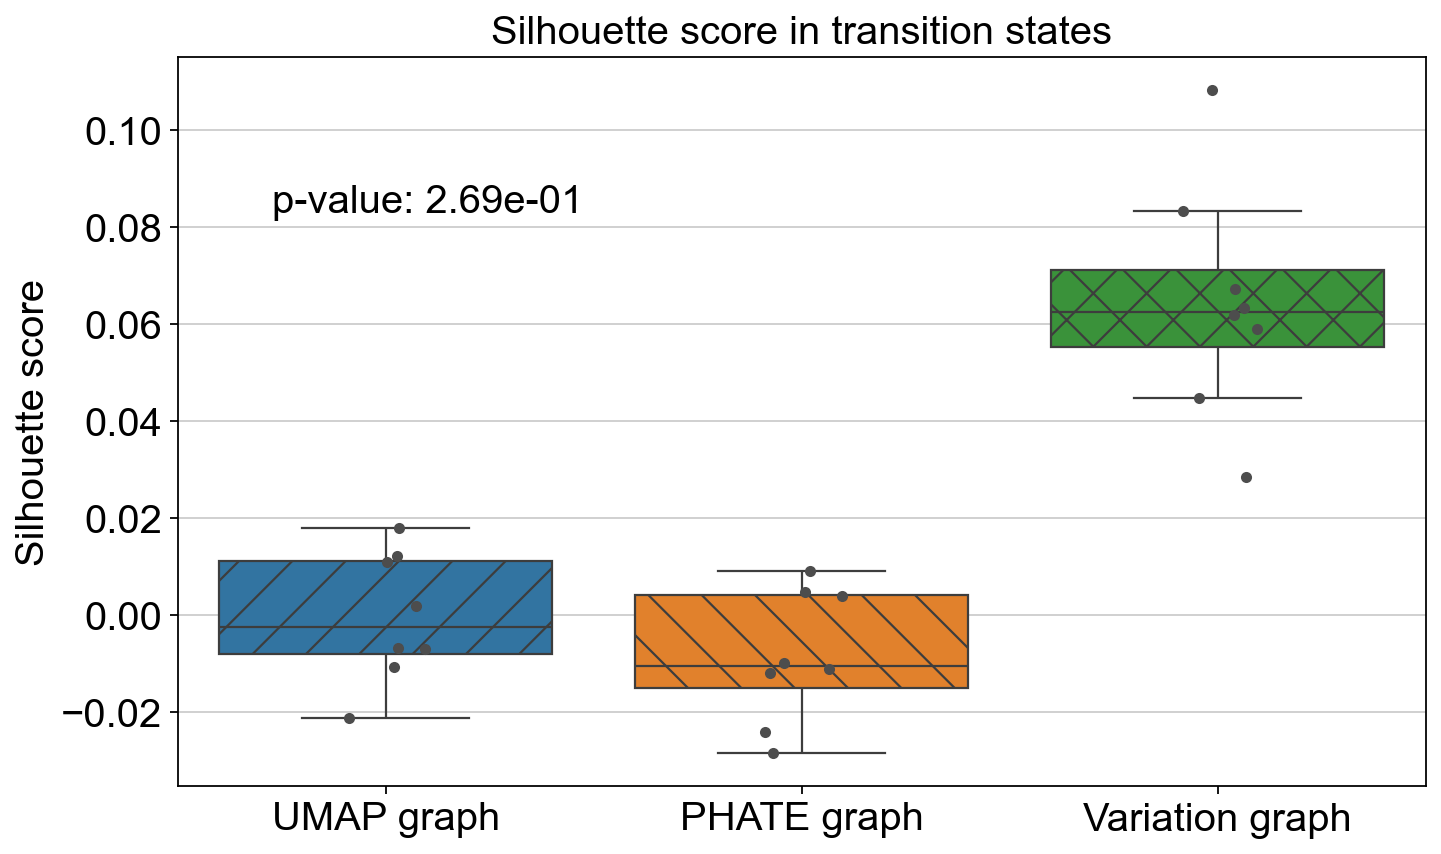

In [20]:
import networkx as nx
from featuremap import core_transition_states
import importlib
importlib.reload(core_transition_states)
from sklearn.metrics import pairwise_distances, silhouette_score
from scipy.stats import ttest_ind, f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

# Graph distance matrices
G_expr = nx.from_numpy_matrix(emb_featuremap.graph_)
G_var = nx.from_numpy_matrix(emb_featuremap_v._featuremap_kwds['graph_v'])
G_phate = phate_graph_nx

# Get the weighted adjacency matrix
adjacency_expr = nx.to_numpy_array(G_expr)
adjacency_var = nx.to_numpy_array(G_var)
adjacency_phate = nx.to_numpy_array(G_phate)

# Compute the distance matrices
dist_mat_expr = pairwise_distances(adjacency_expr, metric='euclidean')
dist_mat_var = pairwise_distances(adjacency_var, metric='euclidean')
dist_mat_phate = pairwise_distances(adjacency_phate, metric='euclidean')

labels = np.array(adata.obs['leiden_v'].values.tolist())
clusters = np.unique(labels)

ss_clusters_expr, ss_clusters_var, ss_clusters_phate = {}, {}, {}

for cluster in clusters:
    cluster_indices = np.where(labels == cluster)[0]
    ss_clusters_expr[cluster] = np.mean([core_transition_states.silhouette_score_one_point(dist_mat_expr, labels, idx) for idx in cluster_indices])
    ss_clusters_var[cluster] = np.mean([core_transition_states.silhouette_score_one_point(dist_mat_var, labels, idx) for idx in cluster_indices])
    ss_clusters_phate[cluster] = np.mean([core_transition_states.silhouette_score_one_point(dist_mat_phate, labels, idx) for idx in cluster_indices])

ss_all = []

def compute_silhouette_scores(state_type, ss_clusters):
    cluster_state_dict = adata.uns['cluster_state_dict']
    states = [cluster for cluster, state in cluster_state_dict.items() if state == state_type]
    return [ss_clusters[cluster] for cluster in states]

ss_all.append(compute_silhouette_scores('transition_states', ss_clusters_expr))
ss_all.append(compute_silhouette_scores('core_states', ss_clusters_expr))

ss_all.append(compute_silhouette_scores('transition_states', ss_clusters_phate))
ss_all.append(compute_silhouette_scores('core_states', ss_clusters_phate))

ss_all.append(compute_silhouette_scores('transition_states', ss_clusters_var))
ss_all.append(compute_silhouette_scores('core_states', ss_clusters_var))

# T test and ANOVA
t_stat, p_val = ttest_ind(ss_all[2], ss_all[3])
print(f'T-test: t_stat: {t_stat}, p_val: {p_val}')

f_stat, p_val = f_oneway(ss_all[4], ss_all[5], ss_all[0])
print(f'ANOVA: f_stat: {f_stat}, p_val: {p_val}')

# Plotting
def plot_silhouette_scores(data, labels, title, p_val):
    plt.figure(figsize=(10, 6))
    box = sns.boxplot(data=data, palette="tab10", showfliers=False)
    hatch_patterns = ['/', '\\', 'x']
    for patch, hatch in zip(box.patches, hatch_patterns):
        patch.set_hatch(hatch)
    sns.stripplot(data=data, color=".3", jitter=True, dodge=True)
    plt.xticks(ticks=range(len(labels)), labels=labels)
    plt.title(title)
    plt.ylabel("Silhouette score")
    plt.text(0.2, 0.8, f"p-value: {p_val:.2e}", ha='center', va='center', transform=plt.gca().transAxes)
    plt.show()

plot_silhouette_scores([ss_all[4], ss_all[5], ss_all[0]], ['UMAP graph', 'PHATE graph', 'Variation graph'], "Silhouette score in core states", p_val)
plot_silhouette_scores([ss_all[0], ss_all[2], ss_all[4]], ['UMAP graph', 'PHATE graph', 'Variation graph'], "Silhouette score in transition states", p_val)


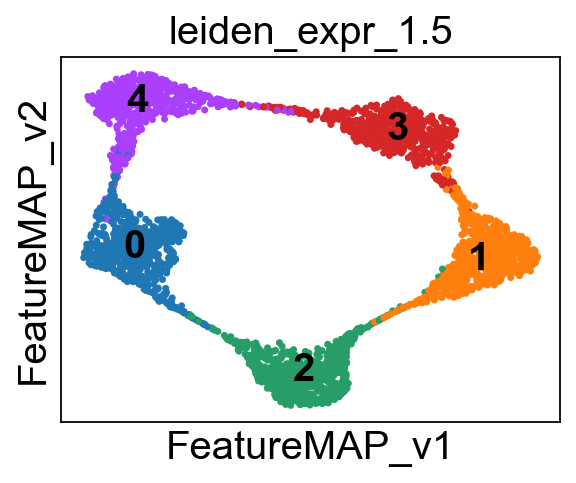

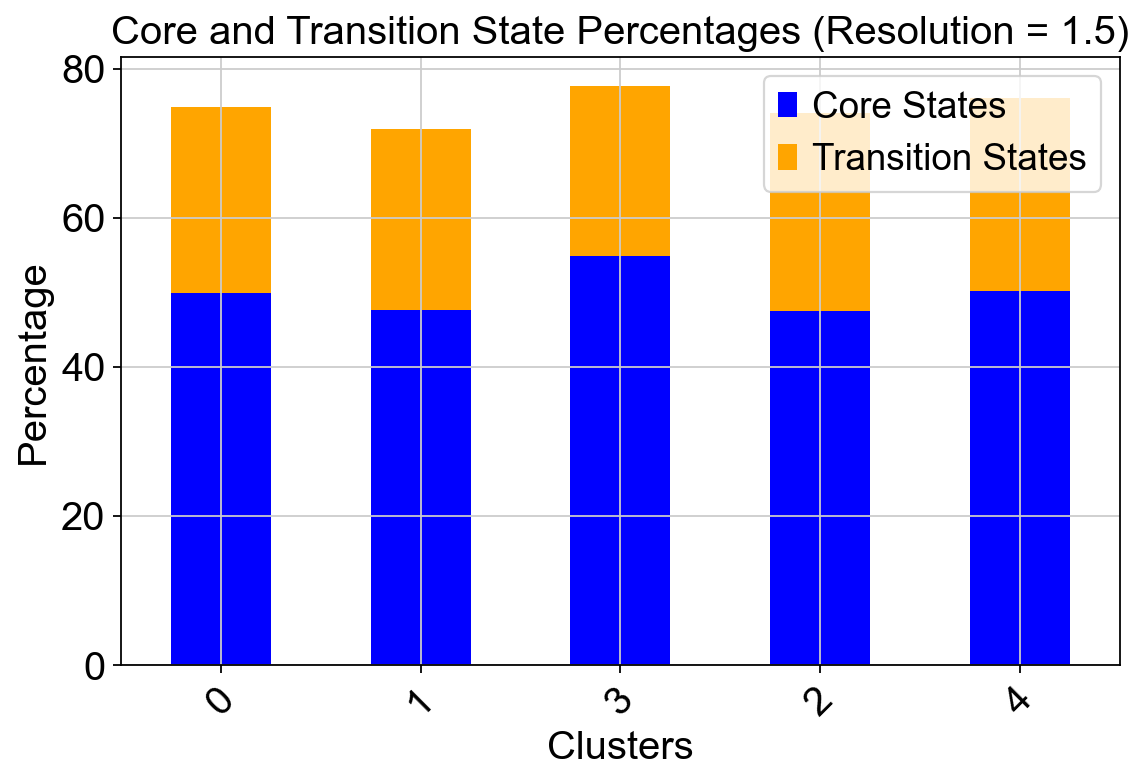

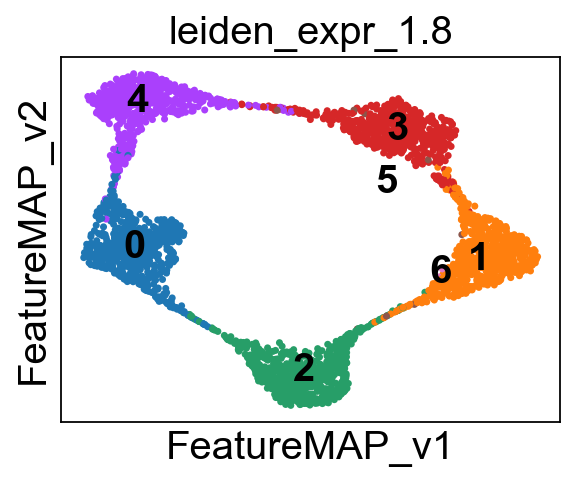

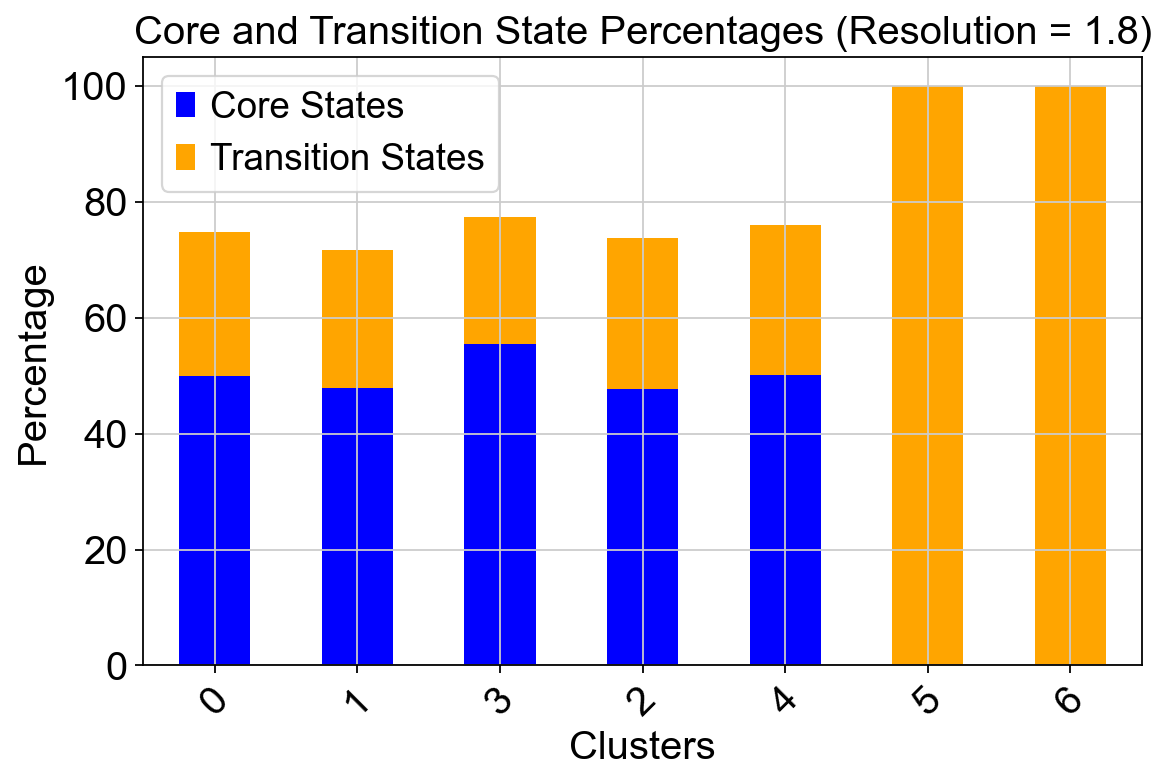

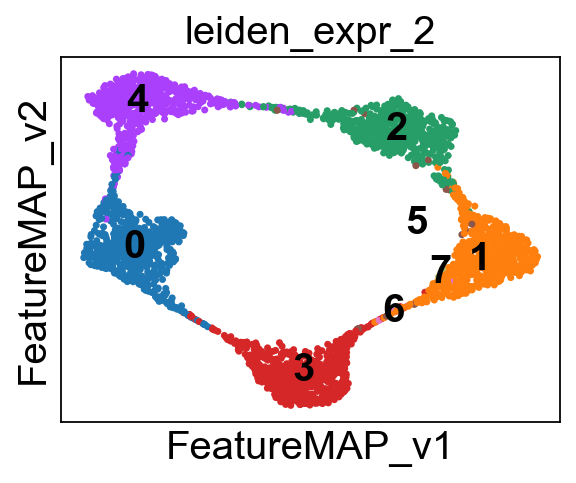

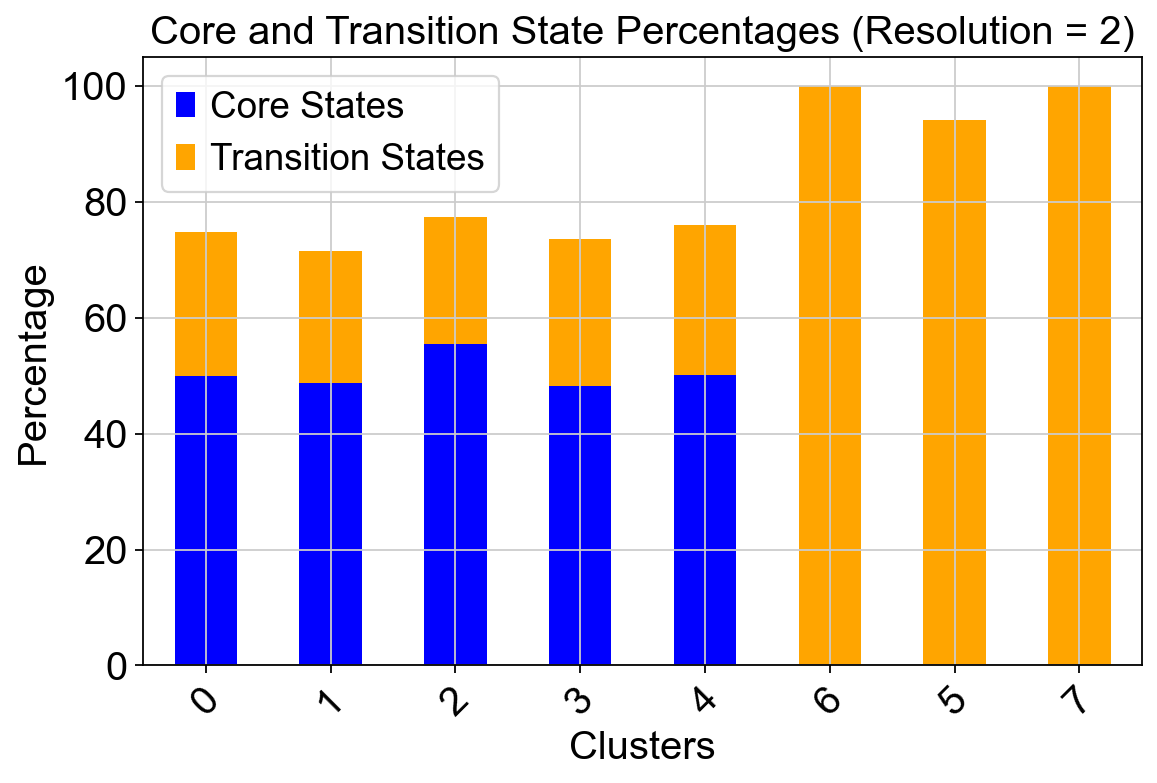

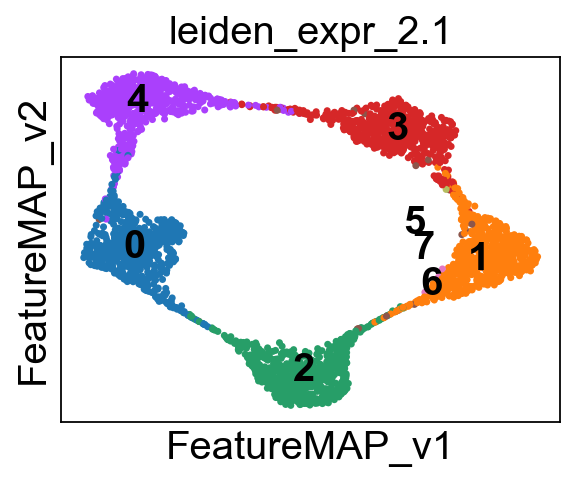

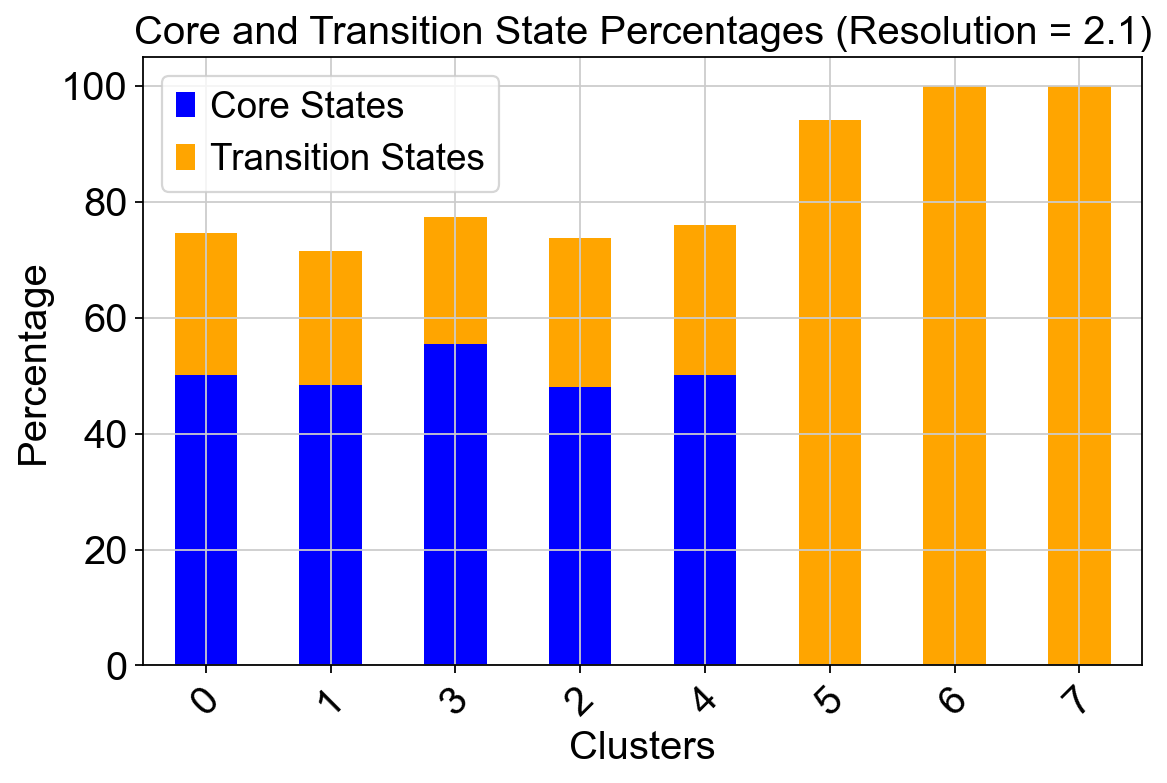

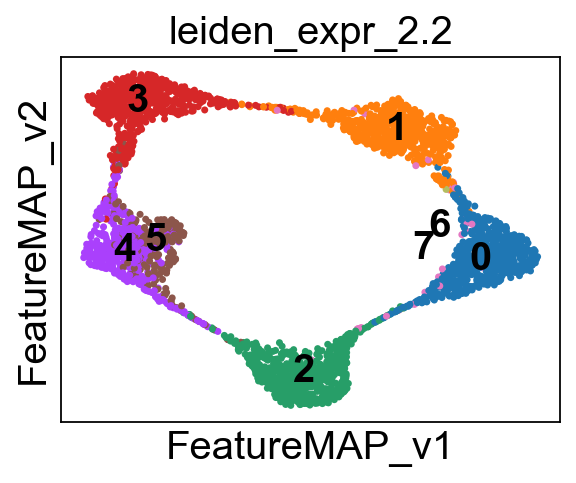

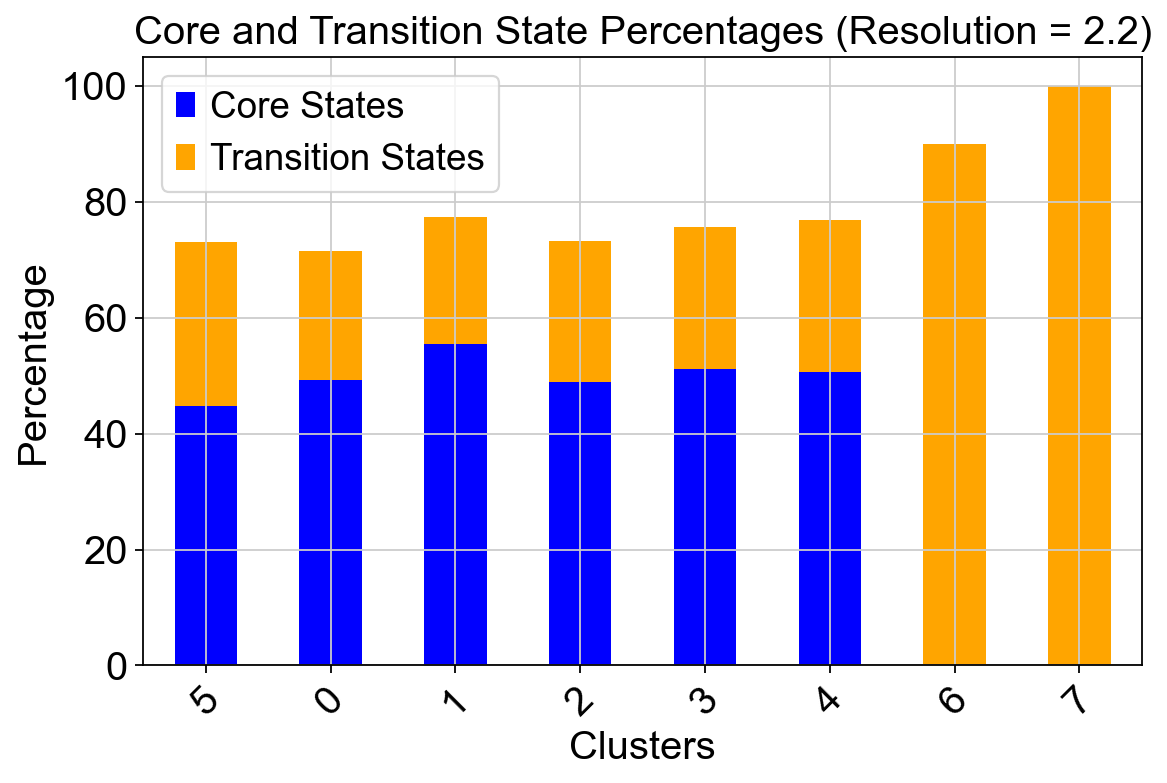

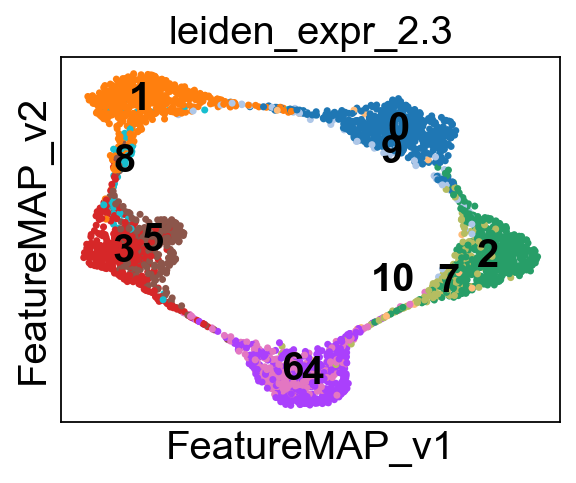

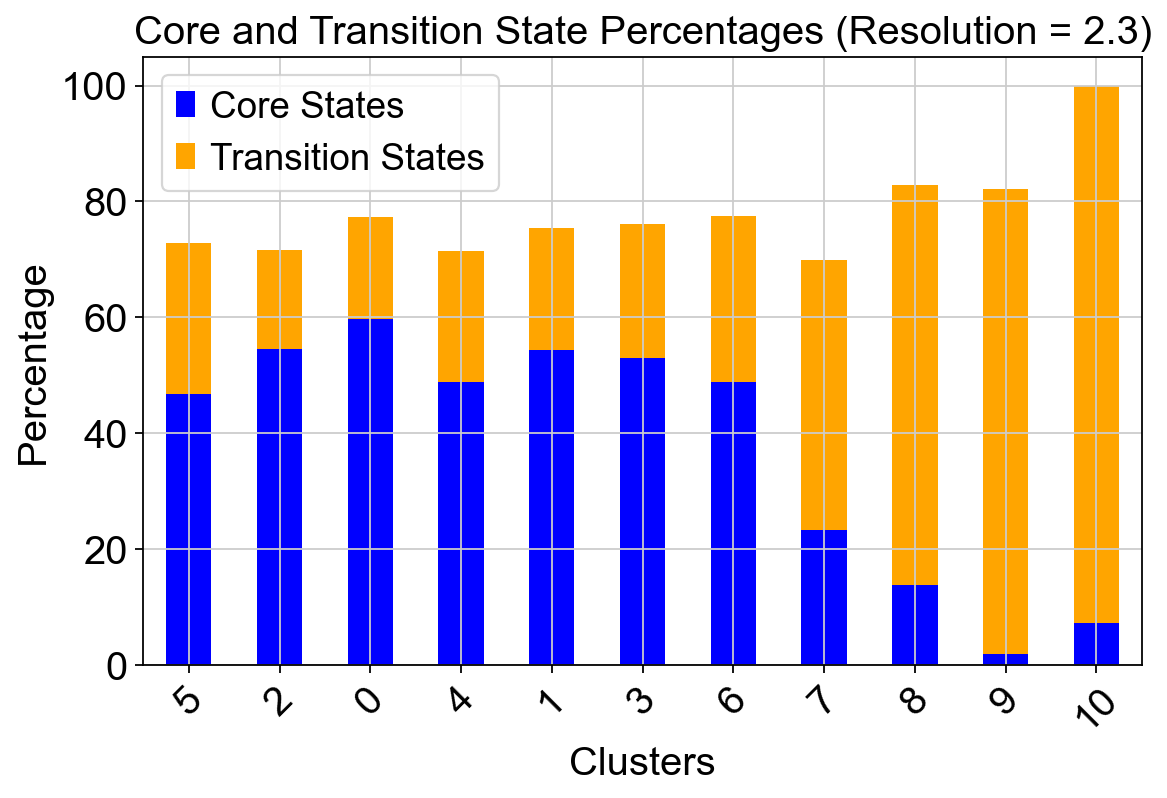

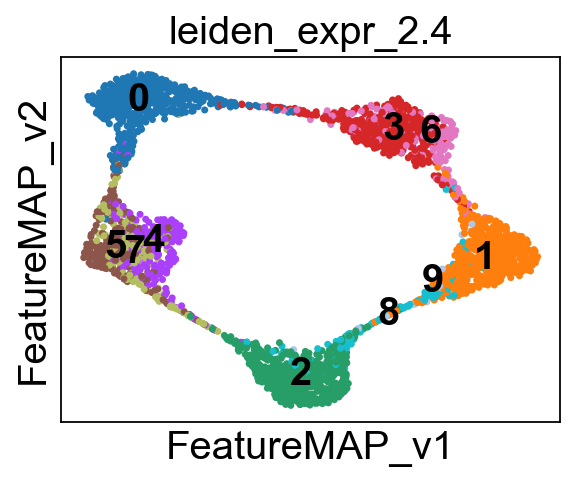

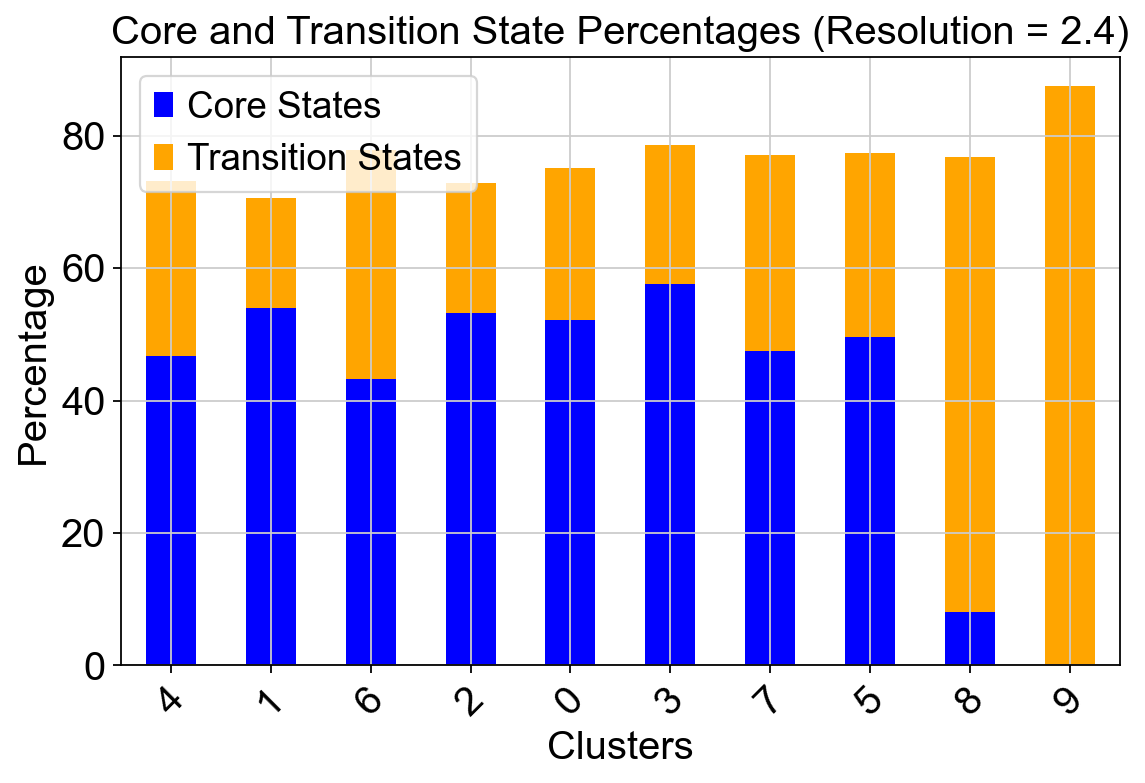

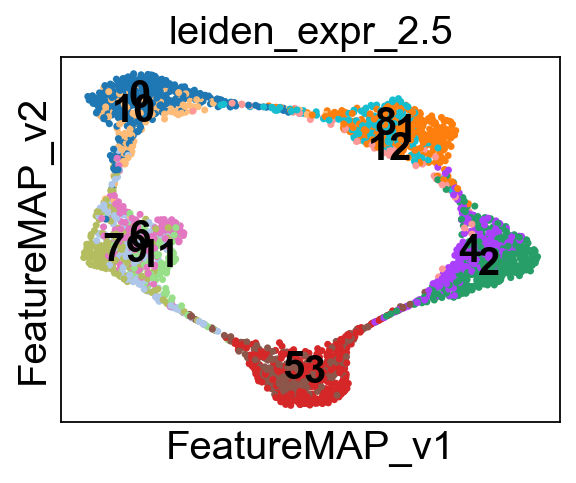

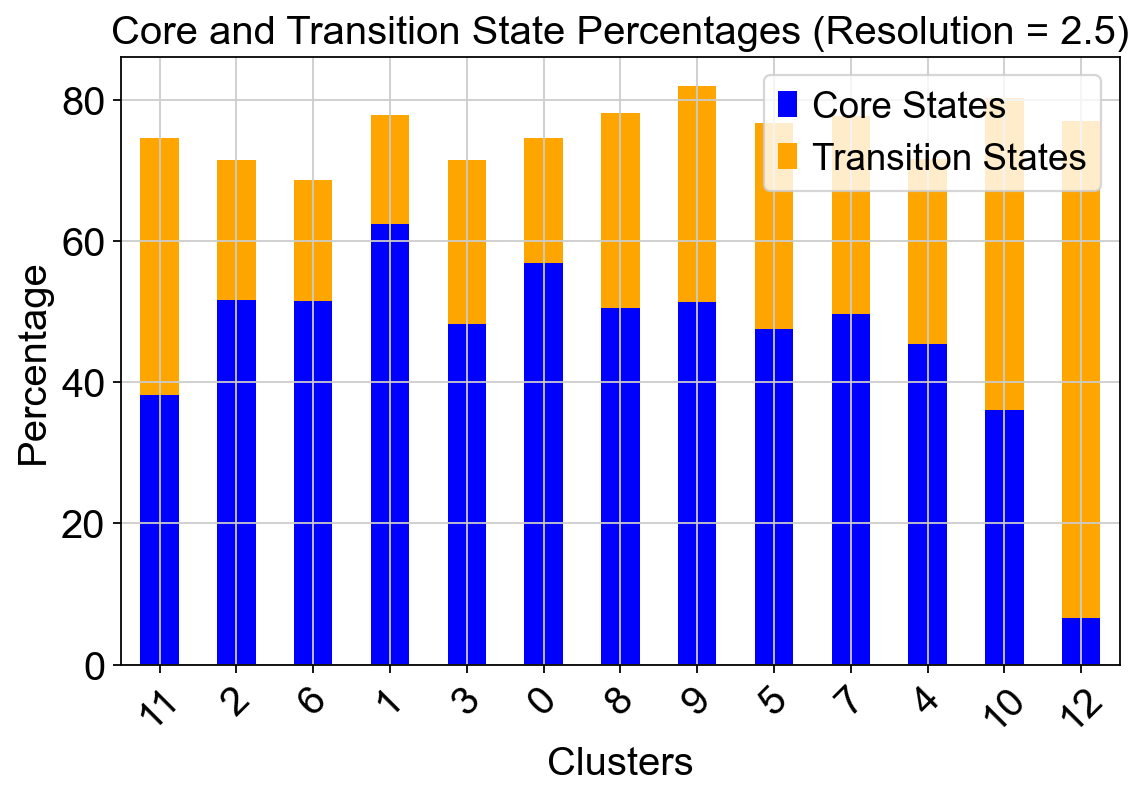

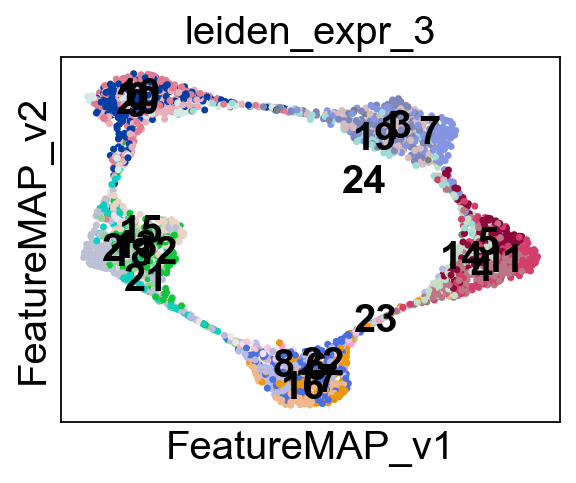

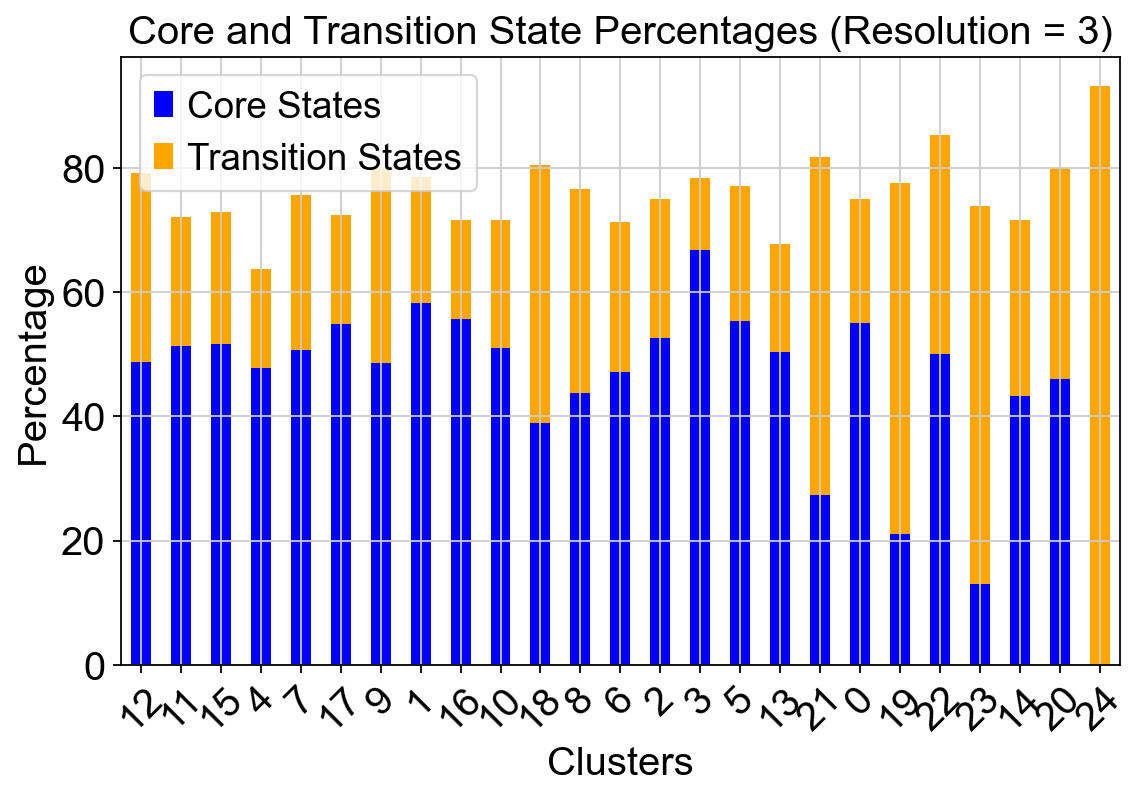

In [21]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# Define resolutions
resolutions = [1.5, 1.8, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 3]

# Dictionaries to store core and transition state percentages
core_states_percentage_dict = {}
transition_states_percentage_dict = {}

for res in resolutions:
    # Perform Leiden clustering for the given resolution
    leiden_key = f'leiden_expr_{res}'
    sc.tl.leiden(adata, resolution=res, key_added=leiden_key) 

    # Visualize clusters on FeatureMAP embedding
    sc.pl.embedding(adata, basis='FeatureMAP_v', color=leiden_key, legend_loc='on data')

    # Initialize storage for cluster-wise percentages
    core_states_percentage = []
    transition_states_percentage = []

    # Compute cluster-wise percentages
    clusters = adata.obs[leiden_key].unique()
    for cluster in clusters:
        cluster_cells = adata.obs[leiden_key] == cluster
        total_cells = cluster_cells.sum()

        core_cells = (adata.obs['core_states']=='1') & cluster_cells
        transition_cells = (adata.obs['transition_states']=='1') & cluster_cells

        core_percentage = (core_cells.sum() / total_cells) * 100
        transition_percentage = (transition_cells.sum() / total_cells) * 100

        core_states_percentage.append(core_percentage)
        transition_states_percentage.append(transition_percentage)

    # Store results in dictionaries
    core_states_percentage_dict[res] = core_states_percentage
    transition_states_percentage_dict[res] = transition_states_percentage

    # Convert to DataFrame for plotting
    df = pd.DataFrame({
        "Cluster": clusters,
        "Core States (%)": core_states_percentage,
        "Transition States (%)": transition_states_percentage
    })

    # Plot for the current resolution
    fig, ax = plt.subplots(figsize=(8, 5))
    df.set_index("Cluster").plot(kind="bar", stacked=True, ax=ax, color=["blue", "orange"])

    ax.set_xlabel("Clusters")
    ax.set_ylabel("Percentage")
    ax.set_title(f"Core and Transition State Percentages (Resolution = {res})")
    ax.legend(["Core States", "Transition States"])

    plt.xticks(rotation=45)
    plt.show()
